In [1]:
%reload_ext autoreload
%autoreload 2

import os
import argparse
import sys
import time

import numpy as np
from multiprocess import Pool

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities import *

%matplotlib inline

Setting environment for Precision WorkStation


No vtk
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
batch_size = 256
model_dir_name = 'inception-bn-blue'
model_name = 'inception-bn-blue'
model, mean_img = load_mxnet_model(model_dir_name=model_dir_name, model_name=model_name, 
                                   num_gpus=1, batch_size=batch_size)

/usr/local/lib/python2.7/dist-packages/mxnet/module/base_module.py:53: UserWarning: You created Module with Module(..., label_names=['softmax_label']) but input with name 'softmax_label' is not found in symbol.list_arguments(). Did you mean one of:
	data
  warnings.warn(msg)
/usr/local/lib/python2.7/dist-packages/mxnet/module/base_module.py:65: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['softmax_label'])
  warnings.warn(msg)


In [3]:
detector_settings

,input_version,windowing_id,feature_network,feature_classifier_id,comments
detector_id,,,,,
1,gray,1,inception-bn-blue,38,NaN
2,grayL500H0,1,inception-bn-blue,38,NaN
3,grayL1000H0,1,inception-bn-blue,38,NaN
4,grayL1500H0,1,inception-bn-blue,38,NaN
5,grayL2000H0,1,inception-bn-blue,38,NaN
6,grayL2500H0,1,inception-bn-blue,38,NaN
7,grayL600H0,1,inception-bn-blue,38,NaN
8,grayL700H0,1,inception-bn-blue,38,NaN
9,grayL800H0,1,inception-bn-blue,38,NaN


In [4]:
stack = 'CHATM3'
# stack = 'MD589'
# stack = 'MD661'

In [5]:
out_resolution_um = 10.
out_resolution_str = '%.1fum' % out_resolution_um

# detector_id = 998
detector_id = 799
# print 'input_version:', detector_settings.loc[detector_id]['input_version']

In [ ]:
detector_setting = detector_settings.loc[detector_id]

In [7]:
detector_setting = {}
detector_setting['feature_classifier_id'] = 899
detector_setting['windowing_id'] = 7

In [8]:
# clfs = DataManager.load_classifiers(classifier_id=detector_setting['feature_classifier_id'], structures=['7N'])

clfs = DataManager.load_classifiers(classifier_id=detector_setting['feature_classifier_id'])
# clfs = {'7N': clfs['7N']}

In [9]:
win_id = detector_setting['windowing_id']

In [10]:
# sections = get_local_regions(stack=stack, by_human=True, suffix='contours', structures=['5N_L'], level=0.5)['5N_L'].keys()
# print np.min(sections), np.max(sections)

In [11]:
# MD598 162-171 5N
# MD661 139-163 5N

In [13]:
atlas_structures_wrt_wholebrainWithMargin_section_limits = load_json('/home/yuncong/' + stack + '_structure_section_limits.json')

In [14]:
atlas_structures_wrt_wholebrainWithMargin_sections = defaultdict(list)
for name_s, (s1, s2) in atlas_structures_wrt_wholebrainWithMargin_section_limits.iteritems():
    atlas_structures_wrt_wholebrainWithMargin_sections[convert_to_original_name(name_s)] += range(max(s1 - 10, metadata_cache['section_limits'][stack][0]), 
                                                                                                  min(s2+1 + 10, metadata_cache['section_limits'][stack][1]))

atlas_structures_wrt_wholebrainWithMargin_sections = {name_s: sorted(set(sec_list)) for name_s, sec_list in atlas_structures_wrt_wholebrainWithMargin_sections.iteritems()}
# atlas_structures_wrt_wholebrainWithMargin_sections.default_factory = None

In [15]:
motor_nuclei = ['Amb', '3N', '4N', '5N', '6N', '7N', '10N', '12N']

In [16]:
# for name_u in all_known_structures:
for name_u in motor_nuclei:
            
    for sec in atlas_structures_wrt_wholebrainWithMargin_sections[name_u]:
        if is_invalid(sec=sec, stack=stack):
            continue

        print name_u, sec
            
        viz_all_landmarks, scoremap_all_landmarks = draw_scoremap(clfs={name_u: clfs[name_u]}, 
                            scheme='none', 
                        win_id=win_id, prep_id=2,
                        stack=stack, return_scoremap=True, sec=sec,
                        model=model, model_name=model_name,
                         mean_img=mean_img, 
                         batch_size=batch_size,
                          output_patch_size=224,
                          is_nissl=False,
                       out_resolution_um=10.,
                    image_shape=metadata_cache['image_shape'][stack])
        
        sm = scoremap_all_landmarks[name_u]
        viz = viz_all_landmarks[name_u]
    
        scoremap_bp_filepath = \
        DataManager.get_downscaled_scoremap_filepath(stack=stack, section=sec, 
                                                     structure=name_u,
                                                     detector_id=detector_id,
                                                     out_resolution_um=out_resolution_um)
        save_data(sm.astype(np.float16), scoremap_bp_filepath, upload_s3=False)

        viz_filepath = \
        DataManager.get_scoremap_viz_filepath_v2(stack=stack, section=sec, 
                                                     structure=name_u,
                                                     detector_id=detector_id,
                                                     out_resolution=out_resolution_str)
        save_data(viz, viz_filepath, upload_s3=False)

        del viz_all_landmarks, scoremap_all_landmarks

Amb 155


locate patches: 0.07 seconds
Load pre-computed features: 1.37 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide53_2018_02_18-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.61 seconds
/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
Rescale background image to output resolution: 6.31 seconds
Predict scores Amb: 0.13 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
Generate scoremap overlay: 0.06 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image Amb: 0.18 seconds


(612, 878, 3) (612, 878)
Amb 156


locate patches: 0.05 seconds
Load pre-computed features: 0.76 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide54_2018_02_18-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.41 seconds
Rescale background image to output resolution: 5.68 seconds
Predict scores Amb: 0.11 seconds
Rescample scoremap Amb: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image Amb: 0.18 seconds


(612, 878, 3) (612, 878)
Amb 157


locate patches: 0.03 seconds
Load pre-computed features: 0.66 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide53_2018_02_18-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.44 seconds
Rescale background image to output resolution: 5.76 seconds
Predict scores Amb: 0.11 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image Amb: 0.17 seconds


(612, 878, 3) (612, 878)
Amb 158


locate patches: 0.06 seconds
Load pre-computed features: 1.19 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide54_2018_02_18-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.39 seconds
Rescale background image to output resolution: 5.96 seconds
Predict scores Amb: 0.11 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image Amb: 0.16 seconds


(612, 878, 3) (612, 878)
Amb 159


locate patches: 0.04 seconds
Load pre-computed features: 0.70 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide53_2018_02_18-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.41 seconds
Rescale background image to output resolution: 5.98 seconds
Predict scores Amb: 0.11 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image Amb: 0.16 seconds


(612, 878, 3) (612, 878)
Amb 160


locate patches: 0.06 seconds
Load pre-computed features: 1.22 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide54_2018_02_18-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.42 seconds
Rescale background image to output resolution: 5.87 seconds
Predict scores Amb: 0.11 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image Amb: 0.17 seconds


(612, 878, 3) (612, 878)
Amb 161


locate patches: 0.02 seconds
Load pre-computed features: 0.74 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide56_2018_02_18-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.53 seconds
Rescale background image to output resolution: 5.84 seconds
Predict scores Amb: 0.11 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image Amb: 0.16 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)
Amb 162


Load pre-computed features: 1.16 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide55_2018_02_18-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.47 seconds
Rescale background image to output resolution: 5.98 seconds
Predict scores Amb: 0.11 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.06 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image Amb: 0.17 seconds


(612, 878, 3) (612, 878)
Amb 163


locate patches: 0.05 seconds
Load pre-computed features: 1.20 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide56_2018_02_18-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.36 seconds
Rescale background image to output resolution: 6.15 seconds
Predict scores Amb: 0.12 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image Amb: 0.16 seconds


(612, 878, 3) (612, 878)
Amb 164


locate patches: 0.02 seconds
Load pre-computed features: 1.25 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide55_2018_02_18-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.45 seconds
Rescale background image to output resolution: 6.17 seconds
Predict scores Amb: 0.11 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image Amb: 0.17 seconds


(612, 878, 3) (612, 878)
Amb 165


locate patches: 0.02 seconds
Load pre-computed features: 0.69 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide56_2018_02_18-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.35 seconds
Rescale background image to output resolution: 6.19 seconds
Predict scores Amb: 0.11 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image Amb: 0.16 seconds


(612, 878, 3) (612, 878)
Amb 166


locate patches: 0.02 seconds
Load pre-computed features: 1.19 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide55_2018_02_18-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.47 seconds
Rescale background image to output resolution: 6.29 seconds
Predict scores Amb: 0.12 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image Amb: 0.17 seconds


(612, 878, 3) (612, 878)
Amb 167


locate patches: 0.05 seconds
Load pre-computed features: 1.32 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide57_2018_02_18-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.37 seconds
Rescale background image to output resolution: 6.29 seconds
Predict scores Amb: 0.11 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image Amb: 0.16 seconds


(612, 878, 3) (612, 878)
Amb 168


locate patches: 0.02 seconds
Load pre-computed features: 1.16 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide58_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.50 seconds
Rescale background image to output resolution: 5.81 seconds
Predict scores Amb: 0.11 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image Amb: 0.17 seconds


(612, 878, 3) (612, 878)
Amb 169


locate patches: 0.04 seconds
Load pre-computed features: 0.67 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide57_2018_02_18-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.41 seconds
Rescale background image to output resolution: 6.86 seconds
Predict scores Amb: 0.11 seconds
Rescample scoremap Amb: 0.06 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image Amb: 0.16 seconds


(612, 878, 3) (612, 878)
Amb 170


locate patches: 0.04 seconds
Load pre-computed features: 0.69 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide58_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.52 seconds
Rescale background image to output resolution: 6.42 seconds
Predict scores Amb: 0.12 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image Amb: 0.16 seconds


(612, 878, 3) (612, 878)
Amb 171


locate patches: 0.05 seconds
Load pre-computed features: 1.24 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide57_2018_02_18-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.48 seconds
Rescale background image to output resolution: 6.29 seconds
Predict scores Amb: 0.12 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image Amb: 0.17 seconds


(612, 878, 3) (612, 878)
Amb 172


locate patches: 0.02 seconds
Load pre-computed features: 1.17 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide58_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.49 seconds
Rescale background image to output resolution: 6.29 seconds
Predict scores Amb: 0.11 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image Amb: 0.16 seconds


(612, 878, 3) (612, 878)
Amb 173


locate patches: 0.04 seconds
Load pre-computed features: 1.27 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide59_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.63 seconds
Rescale background image to output resolution: 6.28 seconds
Predict scores Amb: 0.12 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image Amb: 0.16 seconds


(612, 878, 3) (612, 878)
Amb 174


locate patches: 0.02 seconds
Load pre-computed features: 1.29 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide60_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.73 seconds
Rescale background image to output resolution: 6.44 seconds
Predict scores Amb: 0.13 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.06 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image Amb: 0.17 seconds


(612, 878, 3) (612, 878)
Amb 175


locate patches: 0.04 seconds
Load pre-computed features: 1.27 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide59_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.52 seconds
Rescale background image to output resolution: 6.46 seconds
Predict scores Amb: 0.12 seconds
Rescample scoremap Amb: 0.06 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image Amb: 0.16 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)
Amb 176


Load pre-computed features: 1.30 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide60_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.65 seconds
Rescale background image to output resolution: 6.48 seconds
Predict scores Amb: 0.12 seconds
Rescample scoremap Amb: 0.06 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image Amb: 0.16 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)
Amb 177


Load pre-computed features: 1.32 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide59_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.59 seconds
Rescale background image to output resolution: 6.56 seconds
Predict scores Amb: 0.12 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image Amb: 0.17 seconds


(612, 878, 3) (612, 878)
Amb 178


locate patches: 0.02 seconds
Load pre-computed features: 1.29 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide60_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.56 seconds
Rescale background image to output resolution: 9.33 seconds
Predict scores Amb: 0.12 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image Amb: 0.16 seconds


(612, 878, 3) (612, 878)
Amb 179


locate patches: 0.03 seconds
Load pre-computed features: 1.30 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide61_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.84 seconds
Rescale background image to output resolution: 6.56 seconds
Predict scores Amb: 0.12 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image Amb: 0.16 seconds


(612, 878, 3) (612, 878)
Amb 180


locate patches: 0.05 seconds
Load pre-computed features: 1.43 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide62_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.64 seconds
Rescale background image to output resolution: 7.52 seconds
Predict scores Amb: 0.12 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image Amb: 0.17 seconds


(612, 878, 3) (612, 878)
Amb 182


locate patches: 0.02 seconds
Load pre-computed features: 1.50 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide62_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.52 seconds
Rescale background image to output resolution: 6.66 seconds
Predict scores Amb: 0.12 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image Amb: 0.16 seconds


(612, 878, 3) (612, 878)
Amb 279


locate patches: 0.04 seconds
Load pre-computed features: 1.13 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide93_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.35 seconds
Rescale background image to output resolution: 6.69 seconds
Predict scores Amb: 0.11 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image Amb: 0.17 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)
Amb 281


Load pre-computed features: 0.65 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide95_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.35 seconds
Rescale background image to output resolution: 6.74 seconds
Predict scores Amb: 0.11 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image Amb: 0.16 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)
Amb 283


Load pre-computed features: 1.24 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide95_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.31 seconds
Rescale background image to output resolution: 6.73 seconds
Predict scores Amb: 0.12 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image Amb: 0.16 seconds


(612, 878, 3) (612, 878)
Amb 285


locate patches: 0.02 seconds
Load pre-computed features: 1.30 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide95_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.31 seconds
Rescale background image to output resolution: 6.92 seconds
Predict scores Amb: 0.13 seconds
Rescample scoremap Amb: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image Amb: 0.18 seconds


(612, 878, 3) (612, 878)
Amb 287


locate patches: 0.03 seconds
Load pre-computed features: 1.29 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide97_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.30 seconds
Rescale background image to output resolution: 7.14 seconds
Predict scores Amb: 0.11 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image Amb: 0.17 seconds


(612, 878, 3) (612, 878)
Amb 289


locate patches: 0.04 seconds
Load pre-computed features: 1.27 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide97_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.22 seconds
Rescale background image to output resolution: 6.96 seconds
Predict scores Amb: 0.11 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image Amb: 0.19 seconds


(612, 878, 3) (612, 878)
Amb 291


locate patches: 0.04 seconds
Load pre-computed features: 0.87 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide97_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.94 seconds
Rescale background image to output resolution: 7.04 seconds
Predict scores Amb: 0.08 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image Amb: 0.16 seconds


(612, 878, 3) (612, 878)
Amb 293


locate patches: 0.05 seconds
Load pre-computed features: 1.24 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide99_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.34 seconds
Rescale background image to output resolution: 7.02 seconds
Predict scores Amb: 0.11 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image Amb: 0.17 seconds


(612, 878, 3) (612, 878)
Amb 295


locate patches: 0.03 seconds
Load pre-computed features: 0.68 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide99_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.28 seconds
Rescale background image to output resolution: 6.93 seconds
Predict scores Amb: 0.11 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image Amb: 0.17 seconds


(612, 878, 3) (612, 878)
Amb 297


locate patches: 0.04 seconds
Load pre-computed features: 0.67 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide99_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.20 seconds
Rescale background image to output resolution: 5.79 seconds
Predict scores Amb: 0.11 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image Amb: 0.17 seconds


(612, 878, 3) (612, 878)
Amb 299


locate patches: 0.05 seconds
Load pre-computed features: 1.12 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide101_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.26 seconds
Rescale background image to output resolution: 6.93 seconds
Predict scores Amb: 0.10 seconds
Rescample scoremap Amb: 0.06 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image Amb: 0.17 seconds


(612, 878, 3) (612, 878)
Amb 301


locate patches: 0.06 seconds
Load pre-computed features: 1.09 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide101_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.18 seconds
Rescale background image to output resolution: 6.94 seconds
Predict scores Amb: 0.11 seconds
Rescample scoremap Amb: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image Amb: 0.16 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)
Amb 303


Load pre-computed features: 1.20 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide101_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.19 seconds
Rescale background image to output resolution: 6.94 seconds
Predict scores Amb: 0.12 seconds
Rescample scoremap Amb: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image Amb: 0.16 seconds


(612, 878, 3) (612, 878)
Amb 305


locate patches: 0.05 seconds
Load pre-computed features: 1.18 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide103_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.21 seconds
Rescale background image to output resolution: 6.97 seconds
Predict scores Amb: 0.10 seconds
Rescample scoremap Amb: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image Amb: 0.16 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)
3N 206


Load pre-computed features: 1.34 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide70_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.55 seconds
Rescale background image to output resolution: 7.00 seconds
Predict scores 3N: 0.13 seconds
Rescample scoremap 3N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.06 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 3N: 0.18 seconds


(612, 878, 3) (612, 878)
3N 207


locate patches: 0.02 seconds
Load pre-computed features: 1.10 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide69_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.42 seconds
Rescale background image to output resolution: 7.11 seconds
Predict scores 3N: 0.12 seconds
Rescample scoremap 3N: 0.06 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 3N: 0.17 seconds


(612, 878, 3) (612, 878)
3N 208


locate patches: 0.04 seconds
Load pre-computed features: 0.76 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide70_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.55 seconds
Rescale background image to output resolution: 7.03 seconds
Predict scores 3N: 0.13 seconds
Rescample scoremap 3N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 3N: 0.18 seconds


(612, 878, 3) (612, 878)
3N 209


locate patches: 0.04 seconds
Load pre-computed features: 0.81 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide71_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.61 seconds
Rescale background image to output resolution: 7.01 seconds
Predict scores 3N: 0.13 seconds
Rescample scoremap 3N: 0.06 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 3N: 0.16 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)
3N 210


Load pre-computed features: 0.74 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide72_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.56 seconds
Rescale background image to output resolution: 6.99 seconds
Predict scores 3N: 0.12 seconds
Rescample scoremap 3N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 3N: 0.17 seconds


(612, 878, 3) (612, 878)
3N 211


locate patches: 0.03 seconds
Load pre-computed features: 1.36 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide71_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.58 seconds
Rescale background image to output resolution: 6.99 seconds
Predict scores 3N: 0.13 seconds
Rescample scoremap 3N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 3N: 0.16 seconds


(612, 878, 3) (612, 878)
3N 212


locate patches: 0.05 seconds
Load pre-computed features: 1.54 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide72_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.73 seconds
Rescale background image to output resolution: 7.04 seconds
Predict scores 3N: 0.13 seconds
Rescample scoremap 3N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 3N: 0.17 seconds


(612, 878, 3) (612, 878)
3N 213


locate patches: 0.02 seconds
Load pre-computed features: 1.45 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide71_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.64 seconds
Rescale background image to output resolution: 7.03 seconds
Predict scores 3N: 0.13 seconds
Rescample scoremap 3N: 0.06 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 3N: 0.17 seconds


(612, 878, 3) (612, 878)
3N 214


locate patches: 0.04 seconds
Load pre-computed features: 1.28 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide72_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.70 seconds
Rescale background image to output resolution: 7.06 seconds
Predict scores 3N: 0.13 seconds
Rescample scoremap 3N: 0.06 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 3N: 0.17 seconds


(612, 878, 3) (612, 878)
3N 215


locate patches: 0.05 seconds
Load pre-computed features: 1.37 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide73_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.53 seconds
Rescale background image to output resolution: 7.32 seconds
Predict scores 3N: 0.15 seconds
Rescample scoremap 3N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 3N: 0.17 seconds


(612, 878, 3) (612, 878)
3N 217


locate patches: 0.03 seconds
Load pre-computed features: 1.17 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide73_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.31 seconds
Rescale background image to output resolution: 7.26 seconds
Predict scores 3N: 0.24 seconds
Rescample scoremap 3N: 0.06 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.


(612, 878, 3) (612, 878)
3N 219


Genearte scoremap overlay image 3N: 0.17 seconds
locate patches: 0.05 seconds
Load pre-computed features: 1.17 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide73_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.34 seconds
Rescale background image to output resolution: 7.84 seconds
Predict scores 3N: 0.25 seconds
Rescample scoremap 3N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 3N: 0.17 seconds
locate patches: 0.03 seconds


(612, 878, 3) (612, 878)
3N 221


Load pre-computed features: 1.23 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide75_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.59 seconds
Rescale background image to output resolution: 7.09 seconds
Predict scores 3N: 0.16 seconds
Rescample scoremap 3N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 3N: 0.19 seconds


(612, 878, 3) (612, 878)
3N 223


locate patches: 0.04 seconds
Load pre-computed features: 1.55 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide75_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.60 seconds
Rescale background image to output resolution: 5.75 seconds
Predict scores 3N: 0.19 seconds
Rescample scoremap 3N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.06 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 3N: 0.20 seconds


(612, 878, 3) (612, 878)
3N 225


locate patches: 0.02 seconds
Load pre-computed features: 1.42 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide75_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.53 seconds
Rescale background image to output resolution: 5.65 seconds
Predict scores 3N: 0.17 seconds
Rescample scoremap 3N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 3N: 0.19 seconds


(612, 878, 3) (612, 878)
3N 227


locate patches: 0.02 seconds
Load pre-computed features: 1.31 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide77_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.58 seconds
Rescale background image to output resolution: 6.07 seconds
Predict scores 3N: 0.19 seconds
Rescample scoremap 3N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.06 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 3N: 0.18 seconds


(612, 878, 3) (612, 878)
3N 229


locate patches: 0.05 seconds
Load pre-computed features: 0.77 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide77_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.52 seconds
Rescale background image to output resolution: 5.74 seconds
Predict scores 3N: 0.17 seconds
Rescample scoremap 3N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 3N: 0.16 seconds


(612, 878, 3) (612, 878)
3N 231


locate patches: 0.04 seconds
Load pre-computed features: 0.77 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide77_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.55 seconds
Rescale background image to output resolution: 5.80 seconds
Predict scores 3N: 0.17 seconds
Rescample scoremap 3N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 3N: 0.17 seconds


(612, 878, 3) (612, 878)
3N 233


locate patches: 0.06 seconds
Load pre-computed features: 1.34 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide79_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.56 seconds
Rescale background image to output resolution: 5.88 seconds
Predict scores 3N: 0.19 seconds
Rescample scoremap 3N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 3N: 0.17 seconds


(612, 878, 3) (612, 878)
3N 235


locate patches: 0.06 seconds
Load pre-computed features: 0.74 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide79_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.49 seconds
Rescale background image to output resolution: 6.07 seconds
Predict scores 3N: 0.20 seconds
Rescample scoremap 3N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 3N: 0.17 seconds


(612, 878, 3) (612, 878)
3N 237


locate patches: 0.04 seconds
Load pre-computed features: 1.08 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide79_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.26 seconds
Rescale background image to output resolution: 6.04 seconds
Predict scores 3N: 0.13 seconds
Rescample scoremap 3N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 3N: 0.16 seconds


(612, 878, 3) (612, 878)
3N 245


locate patches: 0.04 seconds
Load pre-computed features: 0.79 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide83_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.67 seconds
Rescale background image to output resolution: 6.83 seconds
Predict scores 3N: 0.14 seconds
Rescample scoremap 3N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 3N: 0.17 seconds


(612, 878, 3) (612, 878)
3N 247


locate patches: 0.02 seconds
Load pre-computed features: 0.81 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide83_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.55 seconds
Rescale background image to output resolution: 5.90 seconds
Predict scores 3N: 0.19 seconds
Rescample scoremap 3N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 3N: 0.17 seconds


(612, 878, 3) (612, 878)
3N 251


locate patches: 0.06 seconds
Load pre-computed features: 0.79 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide85_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.61 seconds
Rescale background image to output resolution: 6.10 seconds
Predict scores 3N: 0.19 seconds
Rescample scoremap 3N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 3N: 0.17 seconds


(612, 878, 3) (612, 878)
3N 253


locate patches: 0.03 seconds
Load pre-computed features: 1.37 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide85_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.61 seconds
Rescale background image to output resolution: 6.07 seconds
Predict scores 3N: 0.17 seconds
Rescample scoremap 3N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 3N: 0.17 seconds


(612, 878, 3) (612, 878)
3N 255


locate patches: 0.04 seconds
Load pre-computed features: 1.43 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide85_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.63 seconds
Rescale background image to output resolution: 6.12 seconds
Predict scores 3N: 0.19 seconds
Rescample scoremap 3N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 3N: 0.17 seconds


(612, 878, 3) (612, 878)
4N 203


locate patches: 0.02 seconds
Load pre-computed features: 1.35 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide69_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 3.00 seconds
Rescale background image to output resolution: 6.17 seconds
Predict scores 4N: 0.19 seconds
Rescample scoremap 4N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 4N: 0.18 seconds


(612, 878, 3) (612, 878)
4N 204


locate patches: 0.05 seconds
Load pre-computed features: 1.36 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide70_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.91 seconds
Rescale background image to output resolution: 6.86 seconds
Predict scores 4N: 0.19 seconds
Rescample scoremap 4N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 4N: 0.19 seconds


(612, 878, 3) (612, 878)
4N 205


locate patches: 0.03 seconds
Load pre-computed features: 1.46 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide69_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.67 seconds
Rescale background image to output resolution: 6.31 seconds
Predict scores 4N: 0.19 seconds
Rescample scoremap 4N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 4N: 0.18 seconds


(612, 878, 3) (612, 878)
4N 206


locate patches: 0.02 seconds
Load pre-computed features: 0.73 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide70_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.65 seconds
Rescale background image to output resolution: 6.20 seconds
Predict scores 4N: 0.19 seconds
Rescample scoremap 4N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 4N: 0.18 seconds


(612, 878, 3) (612, 878)
4N 207


locate patches: 0.02 seconds
Load pre-computed features: 0.75 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide69_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.54 seconds
Rescale background image to output resolution: 6.18 seconds
Predict scores 4N: 0.16 seconds
Rescample scoremap 4N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 4N: 0.18 seconds


(612, 878, 3) (612, 878)
4N 208


locate patches: 0.02 seconds
Load pre-computed features: 0.76 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide70_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.67 seconds
Rescale background image to output resolution: 6.20 seconds
Predict scores 4N: 0.19 seconds
Rescample scoremap 4N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 4N: 0.18 seconds


(612, 878, 3) (612, 878)
4N 209


locate patches: 0.02 seconds
Load pre-computed features: 0.76 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide71_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.72 seconds
Rescale background image to output resolution: 6.18 seconds
Predict scores 4N: 0.18 seconds
Rescample scoremap 4N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 4N: 0.18 seconds


(612, 878, 3) (612, 878)
4N 210


locate patches: 0.02 seconds
Load pre-computed features: 0.74 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide72_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.69 seconds
Rescale background image to output resolution: 6.62 seconds
Predict scores 4N: 0.17 seconds
Rescample scoremap 4N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 4N: 0.19 seconds


(612, 878, 3) (612, 878)
4N 211


locate patches: 0.02 seconds
Load pre-computed features: 0.77 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide71_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.66 seconds
Rescale background image to output resolution: 6.27 seconds
Predict scores 4N: 0.16 seconds
Rescample scoremap 4N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 4N: 0.19 seconds


(612, 878, 3) (612, 878)
4N 212


locate patches: 0.02 seconds
Load pre-computed features: 0.79 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide72_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.79 seconds
Rescale background image to output resolution: 6.29 seconds
Predict scores 4N: 0.19 seconds
Rescample scoremap 4N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 4N: 0.18 seconds


(612, 878, 3) (612, 878)
4N 213


locate patches: 0.02 seconds
Load pre-computed features: 0.84 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide71_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.61 seconds
Rescale background image to output resolution: 6.38 seconds
Predict scores 4N: 0.19 seconds
Rescample scoremap 4N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 4N: 0.18 seconds


(612, 878, 3) (612, 878)
4N 214


locate patches: 0.03 seconds
Load pre-computed features: 0.74 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide72_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.74 seconds
Rescale background image to output resolution: 6.34 seconds
Predict scores 4N: 0.18 seconds
Rescample scoremap 4N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 4N: 0.18 seconds


(612, 878, 3) (612, 878)
4N 215


locate patches: 0.02 seconds
Load pre-computed features: 0.70 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide73_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.41 seconds
Rescale background image to output resolution: 6.27 seconds
Predict scores 4N: 0.15 seconds
Rescample scoremap 4N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 4N: 0.17 seconds


(612, 878, 3) (612, 878)
4N 217


locate patches: 0.02 seconds
Load pre-computed features: 0.60 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide73_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.15 seconds
Rescale background image to output resolution: 6.16 seconds
Predict scores 4N: 0.14 seconds
Rescample scoremap 4N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 4N: 0.17 seconds


(612, 878, 3) (612, 878)
4N 219


locate patches: 0.02 seconds
Load pre-computed features: 0.59 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide73_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.31 seconds
Rescale background image to output resolution: 6.23 seconds
Predict scores 4N: 0.13 seconds
Rescample scoremap 4N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 4N: 0.17 seconds


(612, 878, 3) (612, 878)
4N 221


locate patches: 0.02 seconds
Load pre-computed features: 0.76 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide75_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.46 seconds
Rescale background image to output resolution: 6.28 seconds
Predict scores 4N: 0.18 seconds
Rescample scoremap 4N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 4N: 0.18 seconds


(612, 878, 3) (612, 878)
4N 223


locate patches: 0.02 seconds
Load pre-computed features: 0.77 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide75_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.50 seconds
Rescale background image to output resolution: 6.15 seconds
Predict scores 4N: 0.18 seconds
Rescample scoremap 4N: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 4N: 0.18 seconds


(612, 878, 3) (612, 878)
4N 225


locate patches: 0.02 seconds
Load pre-computed features: 0.76 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide75_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.58 seconds
Rescale background image to output resolution: 6.23 seconds
Predict scores 4N: 0.18 seconds
Rescample scoremap 4N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 4N: 0.18 seconds


(612, 878, 3) (612, 878)
4N 227


locate patches: 0.02 seconds
Load pre-computed features: 0.72 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide77_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.53 seconds
Rescale background image to output resolution: 6.23 seconds
Predict scores 4N: 0.18 seconds
Rescample scoremap 4N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 4N: 0.18 seconds


(612, 878, 3) (612, 878)
4N 229


locate patches: 0.02 seconds
Load pre-computed features: 0.79 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide77_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.50 seconds
Rescale background image to output resolution: 6.35 seconds
Predict scores 4N: 0.16 seconds
Rescample scoremap 4N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 4N: 0.18 seconds


(612, 878, 3) (612, 878)
4N 231


locate patches: 0.02 seconds
Load pre-computed features: 0.77 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide77_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.63 seconds
Rescale background image to output resolution: 6.33 seconds
Predict scores 4N: 0.20 seconds
Rescample scoremap 4N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 4N: 0.19 seconds


(612, 878, 3) (612, 878)
4N 233


locate patches: 0.02 seconds
Load pre-computed features: 0.80 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide79_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.46 seconds
Rescale background image to output resolution: 6.46 seconds
Predict scores 4N: 0.18 seconds
Rescample scoremap 4N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 4N: 0.18 seconds


(612, 878, 3) (612, 878)
4N 235


locate patches: 0.02 seconds
Load pre-computed features: 0.76 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide79_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.35 seconds
Rescale background image to output resolution: 6.29 seconds
Predict scores 4N: 0.16 seconds
Rescample scoremap 4N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 4N: 0.18 seconds


(612, 878, 3) (612, 878)
4N 237


locate patches: 0.02 seconds
Load pre-computed features: 0.59 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide79_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.23 seconds
Rescale background image to output resolution: 6.16 seconds
Predict scores 4N: 0.13 seconds
Rescample scoremap 4N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 4N: 0.17 seconds


(612, 878, 3) (612, 878)
4N 245


locate patches: 0.02 seconds
Load pre-computed features: 0.80 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide83_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.55 seconds
Rescale background image to output resolution: 6.20 seconds
Predict scores 4N: 0.17 seconds
Rescample scoremap 4N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 4N: 0.18 seconds


(612, 878, 3) (612, 878)
4N 247


locate patches: 0.02 seconds
Load pre-computed features: 0.80 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide83_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.60 seconds
Rescale background image to output resolution: 6.44 seconds
Predict scores 4N: 0.19 seconds
Rescample scoremap 4N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 4N: 0.18 seconds


(612, 878, 3) (612, 878)
4N 251


locate patches: 0.02 seconds
Load pre-computed features: 0.78 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide85_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.54 seconds
Rescale background image to output resolution: 6.31 seconds
Predict scores 4N: 0.19 seconds
Rescample scoremap 4N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 4N: 0.19 seconds


(612, 878, 3) (612, 878)
4N 253


locate patches: 0.03 seconds
Load pre-computed features: 0.79 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide85_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.57 seconds
Rescale background image to output resolution: 6.30 seconds
Predict scores 4N: 0.18 seconds
Rescample scoremap 4N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 4N: 0.18 seconds


(612, 878, 3) (612, 878)
4N 255


locate patches: 0.02 seconds
Load pre-computed features: 0.78 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide85_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.58 seconds
Rescale background image to output resolution: 6.28 seconds
Predict scores 4N: 0.18 seconds
Rescample scoremap 4N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 4N: 0.18 seconds


(612, 878, 3) (612, 878)
4N 257


locate patches: 0.02 seconds
Load pre-computed features: 1.85 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide87_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.54 seconds
Rescale background image to output resolution: 6.53 seconds
Predict scores 4N: 0.17 seconds
Rescample scoremap 4N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 4N: 0.18 seconds


(612, 878, 3) (612, 878)
5N 137


locate patches: 0.05 seconds
Load pre-computed features: 1.01 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide47_2018_02_18-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.72 seconds
Rescale background image to output resolution: 6.28 seconds
Predict scores 5N: 0.13 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.16 seconds


(612, 878, 3) (612, 878)
5N 138


locate patches: 0.05 seconds
Load pre-computed features: 0.66 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide48_2018_02_18-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.67 seconds
Rescale background image to output resolution: 6.46 seconds
Predict scores 5N: 0.14 seconds
Rescample scoremap 5N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.16 seconds


(612, 878, 3) (612, 878)
5N 139


locate patches: 0.04 seconds
Load pre-computed features: 1.16 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide47_2018_02_18-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.53 seconds
Rescale background image to output resolution: 6.24 seconds
Predict scores 5N: 0.14 seconds
Rescample scoremap 5N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.16 seconds


(612, 878, 3) (612, 878)
5N 140


locate patches: 0.04 seconds
Load pre-computed features: 1.17 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide48_2018_02_18-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.56 seconds
Rescale background image to output resolution: 6.30 seconds
Predict scores 5N: 0.13 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.16 seconds


(612, 878, 3) (612, 878)
5N 141


locate patches: 0.03 seconds
Load pre-computed features: 1.12 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide47_2018_02_18-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.47 seconds
Rescale background image to output resolution: 6.32 seconds
Predict scores 5N: 0.17 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.16 seconds


(612, 878, 3) (612, 878)
5N 142


locate patches: 0.03 seconds
Load pre-computed features: 1.13 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide48_2018_02_18-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.47 seconds
Rescale background image to output resolution: 6.09 seconds
Predict scores 5N: 0.14 seconds
Rescample scoremap 5N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.16 seconds


(612, 878, 3) (612, 878)
5N 143


locate patches: 0.02 seconds
Load pre-computed features: 1.24 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide49_2018_02_18-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.64 seconds
Rescale background image to output resolution: 6.17 seconds
Predict scores 5N: 0.13 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.16 seconds


(612, 878, 3) (612, 878)
5N 144


locate patches: 0.04 seconds
Load pre-computed features: 1.04 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide50_2018_02_18-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.57 seconds
Rescale background image to output resolution: 6.05 seconds
Predict scores 5N: 0.13 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.16 seconds


(612, 878, 3) (612, 878)
5N 145


locate patches: 0.03 seconds
Load pre-computed features: 1.14 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide49_2018_02_18-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.58 seconds
Rescale background image to output resolution: 6.07 seconds
Predict scores 5N: 0.14 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.17 seconds


(612, 878, 3) (612, 878)
5N 146


locate patches: 0.05 seconds
Load pre-computed features: 1.16 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide50_2018_02_18-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.44 seconds
Rescale background image to output resolution: 5.73 seconds
Predict scores 5N: 0.13 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.16 seconds


(612, 878, 3) (612, 878)
5N 147


locate patches: 0.03 seconds
Load pre-computed features: 1.16 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide49_2018_02_18-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.44 seconds
Rescale background image to output resolution: 5.64 seconds
Predict scores 5N: 0.13 seconds
Rescample scoremap 5N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.16 seconds


(612, 878, 3) (612, 878)
5N 148


locate patches: 0.04 seconds
Load pre-computed features: 0.70 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide50_2018_02_18-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.38 seconds
Rescale background image to output resolution: 5.73 seconds
Predict scores 5N: 0.13 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.16 seconds


(612, 878, 3) (612, 878)
5N 149


locate patches: 0.03 seconds
Load pre-computed features: 0.69 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide51_2018_02_18-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.59 seconds
Rescale background image to output resolution: 5.93 seconds
Predict scores 5N: 0.14 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 5N: 0.17 seconds


(612, 878, 3) (612, 878)
5N 150


locate patches: 0.02 seconds
Load pre-computed features: 0.72 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide52_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.72 seconds
Rescale background image to output resolution: 5.83 seconds
Predict scores 5N: 0.14 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 5N: 0.17 seconds


(612, 878, 3) (612, 878)
5N 151


locate patches: 0.02 seconds
Load pre-computed features: 0.67 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide51_2018_02_18-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.62 seconds
Rescale background image to output resolution: 5.66 seconds
Predict scores 5N: 0.13 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.16 seconds


(612, 878, 3) (612, 878)
5N 153


locate patches: 0.03 seconds
Load pre-computed features: 1.22 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide51_2018_02_18-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.76 seconds
Rescale background image to output resolution: 5.90 seconds
Predict scores 5N: 0.11 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.17 seconds


(612, 878, 3) (612, 878)
5N 154


locate patches: 0.05 seconds
Load pre-computed features: 1.09 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide52_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.75 seconds
Rescale background image to output resolution: 5.83 seconds
Predict scores 5N: 0.11 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 5N: 0.17 seconds


(612, 878, 3) (612, 878)
5N 155


locate patches: 0.02 seconds
Load pre-computed features: 0.96 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide53_2018_02_18-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.47 seconds
Rescale background image to output resolution: 5.77 seconds
Predict scores 5N: 0.11 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.16 seconds


(612, 878, 3) (612, 878)
5N 156


locate patches: 0.05 seconds
Load pre-computed features: 0.65 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide54_2018_02_18-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.60 seconds
Rescale background image to output resolution: 5.99 seconds
Predict scores 5N: 0.12 seconds
Rescample scoremap 5N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.16 seconds


(612, 878, 3) (612, 878)
5N 157


locate patches: 0.03 seconds
Load pre-computed features: 0.76 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide53_2018_02_18-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.53 seconds
Rescale background image to output resolution: 5.69 seconds
Predict scores 5N: 0.11 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.16 seconds


(612, 878, 3) (612, 878)
5N 158


locate patches: 0.03 seconds
Load pre-computed features: 1.16 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide54_2018_02_18-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.48 seconds
Rescale background image to output resolution: 5.65 seconds
Predict scores 5N: 0.11 seconds
Rescample scoremap 5N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.16 seconds


(612, 878, 3) (612, 878)
5N 159


locate patches: 0.02 seconds
Load pre-computed features: 0.64 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide53_2018_02_18-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.60 seconds
Rescale background image to output resolution: 5.69 seconds
Predict scores 5N: 0.12 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.16 seconds


(612, 878, 3) (612, 878)
5N 160


locate patches: 0.04 seconds
Load pre-computed features: 1.20 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide54_2018_02_18-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.55 seconds
Rescale background image to output resolution: 5.80 seconds
Predict scores 5N: 0.11 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.16 seconds


(612, 878, 3) (612, 878)
5N 161


locate patches: 0.02 seconds
Load pre-computed features: 0.67 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide56_2018_02_18-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.62 seconds
Rescale background image to output resolution: 5.73 seconds
Predict scores 5N: 0.11 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.16 seconds


(612, 878, 3) (612, 878)
5N 162


locate patches: 0.03 seconds
Load pre-computed features: 1.14 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide55_2018_02_18-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.58 seconds
Rescale background image to output resolution: 5.91 seconds
Predict scores 5N: 0.11 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.17 seconds


(612, 878, 3) (612, 878)
5N 163


locate patches: 0.03 seconds
Load pre-computed features: 1.20 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide56_2018_02_18-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.34 seconds
Rescale background image to output resolution: 5.74 seconds
Predict scores 5N: 0.11 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.16 seconds


(612, 878, 3) (612, 878)
5N 164


locate patches: 0.03 seconds
Load pre-computed features: 1.22 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide55_2018_02_18-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.55 seconds
Rescale background image to output resolution: 5.69 seconds
Predict scores 5N: 0.11 seconds
Rescample scoremap 5N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.17 seconds


(612, 878, 3) (612, 878)
5N 165


locate patches: 0.04 seconds
Load pre-computed features: 0.79 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide56_2018_02_18-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.50 seconds
Rescale background image to output resolution: 5.81 seconds
Predict scores 5N: 0.11 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.16 seconds


(612, 878, 3) (612, 878)
5N 166


locate patches: 0.02 seconds
Load pre-computed features: 1.20 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide55_2018_02_18-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.45 seconds
Rescale background image to output resolution: 5.76 seconds
Predict scores 5N: 0.12 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 5N: 0.18 seconds


(612, 878, 3) (612, 878)
5N 167


locate patches: 0.03 seconds
Load pre-computed features: 1.18 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide57_2018_02_18-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.37 seconds
Rescale background image to output resolution: 5.61 seconds
Predict scores 5N: 0.11 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.16 seconds


(612, 878, 3) (612, 878)
5N 168


locate patches: 0.03 seconds
Load pre-computed features: 1.25 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide58_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.49 seconds
Rescale background image to output resolution: 5.71 seconds
Predict scores 5N: 0.11 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.16 seconds


(612, 878, 3) (612, 878)
5N 169


locate patches: 0.04 seconds
Load pre-computed features: 0.73 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide57_2018_02_18-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.48 seconds
Rescale background image to output resolution: 6.31 seconds
Predict scores 5N: 0.12 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.16 seconds


(612, 878, 3) (612, 878)
5N 170


locate patches: 0.03 seconds
Load pre-computed features: 0.68 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide58_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.50 seconds
Rescale background image to output resolution: 5.61 seconds
Predict scores 5N: 0.12 seconds
Rescample scoremap 5N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.09 seconds.
Genearte scoremap overlay image 5N: 0.17 seconds


(612, 878, 3) (612, 878)
5N 171


locate patches: 0.04 seconds
Load pre-computed features: 1.27 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide57_2018_02_18-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.43 seconds
Rescale background image to output resolution: 5.51 seconds
Predict scores 5N: 0.12 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.16 seconds


(612, 878, 3) (612, 878)
5N 172


locate patches: 0.02 seconds
Load pre-computed features: 1.19 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide58_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.43 seconds
Rescale background image to output resolution: 5.54 seconds
Predict scores 5N: 0.11 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.16 seconds


(612, 878, 3) (612, 878)
5N 173


locate patches: 0.04 seconds
Load pre-computed features: 1.34 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide59_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.63 seconds
Rescale background image to output resolution: 5.49 seconds
Predict scores 5N: 0.12 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.16 seconds


(612, 878, 3) (612, 878)
5N 174


locate patches: 0.02 seconds
Load pre-computed features: 0.71 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide60_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.65 seconds
Rescale background image to output resolution: 5.53 seconds
Predict scores 5N: 0.12 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 5N: 0.17 seconds


(612, 878, 3) (612, 878)
5N 175


locate patches: 0.02 seconds
Load pre-computed features: 0.75 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide59_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.52 seconds
Rescale background image to output resolution: 5.55 seconds
Predict scores 5N: 0.13 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.16 seconds


(612, 878, 3) (612, 878)
5N 176


locate patches: 0.02 seconds
Load pre-computed features: 0.74 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide60_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.62 seconds
Rescale background image to output resolution: 5.61 seconds
Predict scores 5N: 0.12 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.16 seconds


(612, 878, 3) (612, 878)
5N 177


locate patches: 0.02 seconds
Load pre-computed features: 0.81 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide59_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.49 seconds
Rescale background image to output resolution: 5.46 seconds
Predict scores 5N: 0.12 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.16 seconds


(612, 878, 3) (612, 878)
5N 178


locate patches: 0.02 seconds
Load pre-computed features: 0.74 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide60_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.53 seconds
Rescale background image to output resolution: 5.56 seconds
Predict scores 5N: 0.12 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.16 seconds


(612, 878, 3) (612, 878)
5N 179


locate patches: 0.02 seconds
Load pre-computed features: 0.77 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide61_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.82 seconds
Rescale background image to output resolution: 5.57 seconds
Predict scores 5N: 0.13 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.17 seconds


(612, 878, 3) (612, 878)
5N 180


locate patches: 0.02 seconds
Load pre-computed features: 0.73 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide62_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.56 seconds
Rescale background image to output resolution: 5.46 seconds
Predict scores 5N: 0.12 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.16 seconds


(612, 878, 3) (612, 878)
5N 182


locate patches: 0.02 seconds
Load pre-computed features: 0.75 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide62_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.50 seconds
Rescale background image to output resolution: 5.46 seconds
Predict scores 5N: 0.12 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.16 seconds


(612, 878, 3) (612, 878)
5N 184


locate patches: 0.03 seconds
Load pre-computed features: 1.29 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide62_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.53 seconds
Rescale background image to output resolution: 5.53 seconds
Predict scores 5N: 0.12 seconds
Rescample scoremap 5N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.16 seconds


(612, 878, 3) (612, 878)
5N 185


locate patches: 0.02 seconds
Load pre-computed features: 1.36 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide63_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.61 seconds
Rescale background image to output resolution: 5.55 seconds
Predict scores 5N: 0.12 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.17 seconds


(612, 878, 3) (612, 878)
5N 186


locate patches: 0.04 seconds
Load pre-computed features: 1.36 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide64_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.59 seconds
Rescale background image to output resolution: 5.49 seconds
Predict scores 5N: 0.13 seconds
Rescample scoremap 5N: 0.06 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.16 seconds


(612, 878, 3) (612, 878)
5N 275


locate patches: 0.05 seconds
Load pre-computed features: 0.65 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide93_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.33 seconds
Rescale background image to output resolution: 5.66 seconds
Predict scores 5N: 0.11 seconds
Rescample scoremap 5N: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 5N: 0.17 seconds


(612, 878, 3) (612, 878)
5N 277


locate patches: 0.03 seconds
Load pre-computed features: 1.18 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide93_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.30 seconds
Rescale background image to output resolution: 5.47 seconds
Predict scores 5N: 0.12 seconds
Rescample scoremap 5N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.16 seconds


(612, 878, 3) (612, 878)
5N 279


locate patches: 0.02 seconds
Load pre-computed features: 0.65 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide93_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.28 seconds
Rescale background image to output resolution: 5.54 seconds
Predict scores 5N: 0.12 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 5N: 0.16 seconds


(612, 878, 3) (612, 878)
5N 281


locate patches: 0.02 seconds
Load pre-computed features: 0.68 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide95_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.32 seconds
Rescale background image to output resolution: 5.56 seconds
Predict scores 5N: 0.11 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.06 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.17 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)
5N 283


Load pre-computed features: 0.67 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide95_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.26 seconds
Rescale background image to output resolution: 5.51 seconds
Predict scores 5N: 0.11 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.06 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.17 seconds


(612, 878, 3) (612, 878)
5N 285


locate patches: 0.02 seconds
Load pre-computed features: 0.70 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide95_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.30 seconds
Rescale background image to output resolution: 5.45 seconds
Predict scores 5N: 0.11 seconds
Rescample scoremap 5N: 0.06 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.16 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)
5N 287


Load pre-computed features: 0.65 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide97_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.22 seconds
Rescale background image to output resolution: 5.47 seconds
Predict scores 5N: 0.10 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.16 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)
5N 289


Load pre-computed features: 0.63 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide97_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.20 seconds
Rescale background image to output resolution: 5.92 seconds
Predict scores 5N: 0.18 seconds
Rescample scoremap 5N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 5N: 0.17 seconds


(612, 878, 3) (612, 878)
5N 291


locate patches: 0.02 seconds
Load pre-computed features: 0.48 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide97_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.99 seconds
Rescale background image to output resolution: 5.37 seconds
Predict scores 5N: 0.09 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.15 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)
5N 293


Load pre-computed features: 0.68 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide99_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.27 seconds
Rescale background image to output resolution: 5.46 seconds
Predict scores 5N: 0.12 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.17 seconds


(612, 878, 3) (612, 878)
5N 295


locate patches: 0.02 seconds
Load pre-computed features: 0.63 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide99_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.19 seconds
Rescale background image to output resolution: 5.44 seconds
Predict scores 5N: 0.11 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.16 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)
5N 297


Load pre-computed features: 0.65 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide99_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.16 seconds
Rescale background image to output resolution: 5.41 seconds
Predict scores 5N: 0.11 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.16 seconds


(612, 878, 3) (612, 878)
5N 299


locate patches: 0.02 seconds
Load pre-computed features: 0.66 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide101_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.18 seconds
Rescale background image to output resolution: 5.45 seconds
Predict scores 5N: 0.10 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.16 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)
5N 301


Load pre-computed features: 0.59 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide101_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.13 seconds
Rescale background image to output resolution: 5.46 seconds
Predict scores 5N: 0.10 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.16 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)
5N 303


Load pre-computed features: 0.62 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide101_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.13 seconds
Rescale background image to output resolution: 5.42 seconds
Predict scores 5N: 0.10 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.16 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)
5N 305


Load pre-computed features: 0.66 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide103_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.18 seconds
Rescale background image to output resolution: 5.43 seconds
Predict scores 5N: 0.10 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.16 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)
5N 307


Load pre-computed features: 1.07 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide103_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.19 seconds
Rescale background image to output resolution: 5.46 seconds
Predict scores 5N: 0.10 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.16 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)
5N 309


Load pre-computed features: 1.09 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide103_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.19 seconds
Rescale background image to output resolution: 5.68 seconds
Predict scores 5N: 0.10 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.16 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)
5N 311


Load pre-computed features: 0.63 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide105_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.26 seconds
Rescale background image to output resolution: 5.67 seconds
Predict scores 5N: 0.11 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.16 seconds


(612, 878, 3) (612, 878)
5N 313


locate patches: 0.02 seconds
Load pre-computed features: 1.01 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide105_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.23 seconds
Rescale background image to output resolution: 5.61 seconds
Predict scores 5N: 0.10 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.16 seconds
locate patches: 0.03 seconds


(612, 878, 3) (612, 878)
5N 315


Load pre-computed features: 1.09 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide105_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.20 seconds
Rescale background image to output resolution: 5.68 seconds
Predict scores 5N: 0.10 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 5N: 0.16 seconds


(612, 878, 3) (612, 878)
5N 317


locate patches: 0.05 seconds
Load pre-computed features: 0.66 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide107_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.24 seconds
Rescale background image to output resolution: 5.59 seconds
Predict scores 5N: 0.10 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.09 seconds.
Genearte scoremap overlay image 5N: 0.18 seconds


(612, 878, 3) (612, 878)
5N 319


locate patches: 0.02 seconds
Load pre-computed features: 0.61 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide107_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.17 seconds
Rescale background image to output resolution: 5.93 seconds
Predict scores 5N: 0.10 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 5N: 0.18 seconds


(612, 878, 3) (612, 878)
5N 321


locate patches: 0.03 seconds
Load pre-computed features: 1.00 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide107_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.19 seconds
Rescale background image to output resolution: 5.73 seconds
Predict scores 5N: 0.10 seconds
Rescample scoremap 5N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.06 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 5N: 0.18 seconds


(612, 878, 3) (612, 878)
6N 196


locate patches: 0.03 seconds
Load pre-computed features: 1.30 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide66_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.53 seconds
Rescale background image to output resolution: 8.27 seconds
Predict scores 6N: 0.13 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.06 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 6N: 0.19 seconds


(612, 878, 3) (612, 878)
6N 197


locate patches: 0.03 seconds
Load pre-computed features: 1.48 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide67_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.76 seconds
Rescale background image to output resolution: 5.54 seconds
Predict scores 6N: 0.14 seconds
Rescample scoremap 6N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 6N: 0.18 seconds


(612, 878, 3) (612, 878)
6N 198


locate patches: 0.03 seconds
Load pre-computed features: 1.34 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide68_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.89 seconds
Rescale background image to output resolution: 5.42 seconds
Predict scores 6N: 0.13 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 6N: 0.19 seconds


(612, 878, 3) (612, 878)
6N 199


locate patches: 0.03 seconds
Load pre-computed features: 1.37 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide67_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.58 seconds
Rescale background image to output resolution: 5.46 seconds
Predict scores 6N: 0.13 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 6N: 0.18 seconds


(612, 878, 3) (612, 878)
6N 200


locate patches: 0.05 seconds
Load pre-computed features: 1.38 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide68_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.65 seconds
Rescale background image to output resolution: 5.48 seconds
Predict scores 6N: 0.13 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 6N: 0.19 seconds


(612, 878, 3) (612, 878)
6N 201


locate patches: 0.05 seconds
Load pre-computed features: 1.31 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide67_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.57 seconds
Rescale background image to output resolution: 5.74 seconds
Predict scores 6N: 0.13 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 6N: 0.20 seconds


(612, 878, 3) (612, 878)
6N 202


locate patches: 0.06 seconds
Load pre-computed features: 1.31 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide68_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.67 seconds
Rescale background image to output resolution: 5.76 seconds
Predict scores 6N: 0.13 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 6N: 0.19 seconds


(612, 878, 3) (612, 878)
6N 203


locate patches: 0.02 seconds
Load pre-computed features: 0.74 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide69_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.70 seconds
Rescale background image to output resolution: 6.95 seconds
Predict scores 6N: 0.19 seconds
Rescample scoremap 6N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 6N: 0.20 seconds


(612, 878, 3) (612, 878)
6N 204


locate patches: 0.03 seconds
Load pre-computed features: 0.73 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide70_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.67 seconds
Rescale background image to output resolution: 5.60 seconds
Predict scores 6N: 0.13 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.06 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 6N: 0.19 seconds


(612, 878, 3) (612, 878)
6N 205


locate patches: 0.02 seconds
Load pre-computed features: 0.73 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide69_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.50 seconds
Rescale background image to output resolution: 5.62 seconds
Predict scores 6N: 0.13 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 6N: 0.18 seconds


(612, 878, 3) (612, 878)
6N 206


locate patches: 0.02 seconds
Load pre-computed features: 0.73 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide70_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.56 seconds
Rescale background image to output resolution: 5.69 seconds
Predict scores 6N: 0.13 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 6N: 0.18 seconds


(612, 878, 3) (612, 878)
6N 207


locate patches: 0.02 seconds
Load pre-computed features: 0.69 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide69_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.42 seconds
Rescale background image to output resolution: 5.70 seconds
Predict scores 6N: 0.12 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 6N: 0.18 seconds


(612, 878, 3) (612, 878)
6N 208


locate patches: 0.02 seconds
Load pre-computed features: 0.75 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide70_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.54 seconds
Rescale background image to output resolution: 5.65 seconds
Predict scores 6N: 0.13 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.09 seconds.
Genearte scoremap overlay image 6N: 0.20 seconds


(612, 878, 3) (612, 878)
6N 209


locate patches: 0.02 seconds
Load pre-computed features: 0.75 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide71_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.61 seconds
Rescale background image to output resolution: 5.55 seconds
Predict scores 6N: 0.13 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 6N: 0.20 seconds


(612, 878, 3) (612, 878)
6N 210


locate patches: 0.03 seconds
Load pre-computed features: 0.72 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide72_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.46 seconds
Rescale background image to output resolution: 5.55 seconds
Predict scores 6N: 0.12 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 6N: 0.18 seconds


(612, 878, 3) (612, 878)
6N 211


locate patches: 0.02 seconds
Load pre-computed features: 0.82 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide71_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.49 seconds
Rescale background image to output resolution: 5.58 seconds
Predict scores 6N: 0.13 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.06 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 6N: 0.19 seconds


(612, 878, 3) (612, 878)
6N 212


locate patches: 0.02 seconds
Load pre-computed features: 0.77 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide72_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.53 seconds
Rescale background image to output resolution: 5.57 seconds
Predict scores 6N: 0.13 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 6N: 0.18 seconds


(612, 878, 3) (612, 878)
6N 213


locate patches: 0.02 seconds
Load pre-computed features: 0.76 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide71_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.44 seconds
Rescale background image to output resolution: 5.56 seconds
Predict scores 6N: 0.13 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 6N: 0.18 seconds


(612, 878, 3) (612, 878)
6N 214


locate patches: 0.02 seconds
Load pre-computed features: 0.73 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide72_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.44 seconds
Rescale background image to output resolution: 5.57 seconds
Predict scores 6N: 0.12 seconds
Rescample scoremap 6N: 0.06 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.06 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 6N: 0.19 seconds


(612, 878, 3) (612, 878)
6N 215


locate patches: 0.02 seconds
Load pre-computed features: 0.68 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide73_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.21 seconds
Rescale background image to output resolution: 5.55 seconds
Predict scores 6N: 0.11 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 6N: 0.18 seconds


(612, 878, 3) (612, 878)
6N 217


locate patches: 0.02 seconds
Load pre-computed features: 0.61 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide73_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.04 seconds
Rescale background image to output resolution: 5.72 seconds
Predict scores 6N: 0.10 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 6N: 0.19 seconds


(612, 878, 3) (612, 878)
6N 219


locate patches: 0.02 seconds
Load pre-computed features: 0.57 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide73_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.07 seconds
Rescale background image to output resolution: 5.66 seconds
Predict scores 6N: 0.10 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.06 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 6N: 0.18 seconds


(612, 878, 3) (612, 878)
6N 221


locate patches: 0.02 seconds
Load pre-computed features: 0.74 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide75_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.28 seconds
Rescale background image to output resolution: 5.61 seconds
Predict scores 6N: 0.12 seconds
Rescample scoremap 6N: 0.06 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 6N: 0.19 seconds


(612, 878, 3) (612, 878)
6N 223


locate patches: 0.02 seconds
Load pre-computed features: 0.76 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide75_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.35 seconds
Rescale background image to output resolution: 5.99 seconds
Predict scores 6N: 0.13 seconds
Rescample scoremap 6N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.


(612, 878, 3) (612, 878)
6N 225


Genearte scoremap overlay image 6N: 0.21 seconds
locate patches: 0.02 seconds
Load pre-computed features: 0.74 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide75_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.37 seconds
Rescale background image to output resolution: 5.72 seconds
Predict scores 6N: 0.13 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 6N: 0.18 seconds


(612, 878, 3) (612, 878)
6N 227


locate patches: 0.02 seconds
Load pre-computed features: 0.77 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide77_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.40 seconds
Rescale background image to output resolution: 5.56 seconds
Predict scores 6N: 0.13 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 6N: 0.18 seconds


(612, 878, 3) (612, 878)
6N 233


locate patches: 0.02 seconds
Load pre-computed features: 0.70 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide79_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.30 seconds
Rescale background image to output resolution: 5.57 seconds
Predict scores 6N: 0.12 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 6N: 0.19 seconds


(612, 878, 3) (612, 878)
6N 235


locate patches: 0.02 seconds
Load pre-computed features: 0.72 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide79_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.25 seconds
Rescale background image to output resolution: 5.60 seconds
Predict scores 6N: 0.12 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 6N: 0.18 seconds


(612, 878, 3) (612, 878)
6N 237


locate patches: 0.02 seconds
Load pre-computed features: 0.58 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide79_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.12 seconds
Rescale background image to output resolution: 5.68 seconds
Predict scores 6N: 0.10 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 6N: 0.18 seconds


(612, 878, 3) (612, 878)
6N 245


locate patches: 0.03 seconds
Load pre-computed features: 0.77 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide83_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.40 seconds
Rescale background image to output resolution: 5.95 seconds
Predict scores 6N: 0.13 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 6N: 0.19 seconds


(612, 878, 3) (612, 878)
6N 247


locate patches: 0.02 seconds
Load pre-computed features: 0.76 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide83_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.37 seconds
Rescale background image to output resolution: 5.77 seconds
Predict scores 6N: 0.13 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 6N: 0.20 seconds


(612, 878, 3) (612, 878)
6N 251


locate patches: 0.02 seconds
Load pre-computed features: 0.80 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide85_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.38 seconds
Rescale background image to output resolution: 5.74 seconds
Predict scores 6N: 0.13 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 6N: 0.18 seconds


(612, 878, 3) (612, 878)
6N 253


locate patches: 0.02 seconds
Load pre-computed features: 0.72 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide85_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.38 seconds
Rescale background image to output resolution: 5.75 seconds
Predict scores 6N: 0.12 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 6N: 0.18 seconds


(612, 878, 3) (612, 878)
6N 255


locate patches: 0.02 seconds
Load pre-computed features: 0.74 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide85_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.34 seconds
Rescale background image to output resolution: 5.80 seconds
Predict scores 6N: 0.13 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 6N: 0.18 seconds


(612, 878, 3) (612, 878)
6N 257


locate patches: 0.02 seconds
Load pre-computed features: 0.71 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide87_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.38 seconds
Rescale background image to output resolution: 6.13 seconds
Predict scores 6N: 0.13 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 6N: 0.18 seconds


(612, 878, 3) (612, 878)
6N 259


locate patches: 0.31 seconds
Load pre-computed features: 0.68 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide87_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.46 seconds
Rescale background image to output resolution: 6.18 seconds
Predict scores 6N: 0.13 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 6N: 0.18 seconds


(612, 878, 3) (612, 878)
6N 261


locate patches: 0.04 seconds
Load pre-computed features: 1.32 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide87_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.41 seconds
Rescale background image to output resolution: 5.99 seconds
Predict scores 6N: 0.12 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 6N: 0.18 seconds


(612, 878, 3) (612, 878)
6N 263


locate patches: 0.02 seconds
Load pre-computed features: 0.75 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide89_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.48 seconds
Rescale background image to output resolution: 6.09 seconds
Predict scores 6N: 0.12 seconds
Rescample scoremap 6N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 6N: 0.18 seconds


(612, 878, 3) (612, 878)
7N 139


locate patches: 0.02 seconds
Load pre-computed features: 0.63 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide47_2018_02_18-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.34 seconds
Rescale background image to output resolution: 7.21 seconds
Predict scores 7N: 0.10 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)
7N 140


Load pre-computed features: 0.64 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide48_2018_02_18-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.32 seconds
Rescale background image to output resolution: 5.98 seconds
Predict scores 7N: 0.10 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)
7N 141


Load pre-computed features: 0.65 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide47_2018_02_18-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.24 seconds
Rescale background image to output resolution: 5.98 seconds
Predict scores 7N: 0.10 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)
7N 142


Load pre-computed features: 0.58 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide48_2018_02_18-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.23 seconds
Rescale background image to output resolution: 6.54 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)
7N 143


Load pre-computed features: 0.60 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide49_2018_02_18-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.44 seconds
Rescale background image to output resolution: 6.11 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)
7N 144


Load pre-computed features: 0.60 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide50_2018_02_18-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.30 seconds
Rescale background image to output resolution: 5.84 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)
7N 145


locate patches: 0.02 seconds
Load pre-computed features: 0.62 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide49_2018_02_18-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.31 seconds
Rescale background image to output resolution: 6.15 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)
7N 146


locate patches: 0.02 seconds
Load pre-computed features: 0.65 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide50_2018_02_18-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.35 seconds
Rescale background image to output resolution: 6.50 seconds
Predict scores 7N: 0.16 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 7N: 0.18 seconds


(612, 878, 3) (612, 878)
7N 147


locate patches: 0.02 seconds
Load pre-computed features: 0.62 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide49_2018_02_18-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.47 seconds
Rescale background image to output resolution: 6.60 seconds
Predict scores 7N: 0.14 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.06 seconds.
Scoremap size does not match background image size. Need to resize: 0.09 seconds.


(612, 878, 3) (612, 878)
7N 148


Genearte scoremap overlay image 7N: 0.21 seconds
locate patches: 0.02 seconds
Load pre-computed features: 0.66 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide50_2018_02_18-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.48 seconds
Rescale background image to output resolution: 6.91 seconds
Predict scores 7N: 0.13 seconds
Rescample scoremap 7N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 7N: 0.20 seconds


(612, 878, 3) (612, 878)
7N 149


locate patches: 0.03 seconds
Load pre-computed features: 0.64 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide51_2018_02_18-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.53 seconds
Rescale background image to output resolution: 6.40 seconds
Predict scores 7N: 0.20 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.06 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 7N: 0.19 seconds


(612, 878, 3) (612, 878)
7N 150


locate patches: 0.02 seconds
Load pre-computed features: 0.75 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide52_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.67 seconds
Rescale background image to output resolution: 6.09 seconds
Predict scores 7N: 0.20 seconds
Rescample scoremap 7N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 7N: 0.18 seconds


(612, 878, 3) (612, 878)
7N 151


locate patches: 0.03 seconds
Load pre-computed features: 1.20 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide51_2018_02_18-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.56 seconds
Rescale background image to output resolution: 5.98 seconds
Predict scores 7N: 0.14 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)
7N 153


locate patches: 0.02 seconds
Load pre-computed features: 1.16 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide51_2018_02_18-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.73 seconds
Rescale background image to output resolution: 5.78 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)
7N 154


locate patches: 0.04 seconds
Load pre-computed features: 1.11 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide52_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.58 seconds
Rescale background image to output resolution: 5.43 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.06 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 7N: 0.20 seconds


(612, 878, 3) (612, 878)
7N 155


locate patches: 0.03 seconds
Load pre-computed features: 0.63 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide53_2018_02_18-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.34 seconds
Rescale background image to output resolution: 5.34 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.06 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 7N: 0.19 seconds


(612, 878, 3) (612, 878)
7N 156


locate patches: 0.02 seconds
Load pre-computed features: 1.17 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide54_2018_02_18-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.36 seconds
Rescale background image to output resolution: 5.40 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)
7N 157


locate patches: 0.02 seconds
Load pre-computed features: 0.68 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide53_2018_02_18-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.39 seconds
Rescale background image to output resolution: 5.51 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)
7N 158


locate patches: 0.02 seconds
Load pre-computed features: 0.64 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide54_2018_02_18-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.33 seconds
Rescale background image to output resolution: 5.41 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)
7N 159


Load pre-computed features: 1.23 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide53_2018_02_18-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.48 seconds
Rescale background image to output resolution: 5.65 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)
7N 160


locate patches: 0.02 seconds
Load pre-computed features: 0.67 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide54_2018_02_18-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.29 seconds
Rescale background image to output resolution: 5.41 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)
7N 161


locate patches: 0.02 seconds
Load pre-computed features: 0.78 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide56_2018_02_18-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.46 seconds
Rescale background image to output resolution: 5.37 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)
7N 162


locate patches: 0.02 seconds
Load pre-computed features: 0.64 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide55_2018_02_18-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.43 seconds
Rescale background image to output resolution: 5.36 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)
7N 163


locate patches: 0.02 seconds
Load pre-computed features: 0.77 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide56_2018_02_18-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.33 seconds
Rescale background image to output resolution: 5.33 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)
7N 164


locate patches: 0.02 seconds
Load pre-computed features: 0.72 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide55_2018_02_18-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.43 seconds
Rescale background image to output resolution: 5.55 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)
7N 165


locate patches: 0.03 seconds
Load pre-computed features: 0.70 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide56_2018_02_18-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.35 seconds
Rescale background image to output resolution: 5.49 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)
7N 166


locate patches: 0.02 seconds
Load pre-computed features: 0.70 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide55_2018_02_18-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.40 seconds
Rescale background image to output resolution: 5.31 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)
7N 167


locate patches: 0.02 seconds
Load pre-computed features: 0.65 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide57_2018_02_18-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.34 seconds
Rescale background image to output resolution: 5.34 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)
7N 168


locate patches: 0.02 seconds
Load pre-computed features: 0.68 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide58_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.50 seconds
Rescale background image to output resolution: 5.41 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)
7N 169


locate patches: 0.02 seconds
Load pre-computed features: 0.89 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide57_2018_02_18-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.38 seconds
Rescale background image to output resolution: 5.38 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)
7N 170


Load pre-computed features: 0.70 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide58_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.42 seconds
Rescale background image to output resolution: 5.41 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)
7N 171


locate patches: 0.02 seconds
Load pre-computed features: 0.68 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide57_2018_02_18-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.38 seconds
Rescale background image to output resolution: 5.32 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)
7N 172


locate patches: 0.02 seconds
Load pre-computed features: 0.65 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide58_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.39 seconds
Rescale background image to output resolution: 5.57 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)
7N 173


locate patches: 0.02 seconds
Load pre-computed features: 0.77 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide59_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.64 seconds
Rescale background image to output resolution: 5.35 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)
7N 174


locate patches: 0.02 seconds
Load pre-computed features: 0.75 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide60_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.70 seconds
Rescale background image to output resolution: 5.45 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)
7N 175


locate patches: 0.02 seconds
Load pre-computed features: 0.77 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide59_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.53 seconds
Rescale background image to output resolution: 5.33 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)
7N 176


locate patches: 0.02 seconds
Load pre-computed features: 0.74 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide60_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.59 seconds
Rescale background image to output resolution: 5.30 seconds
Predict scores 7N: 0.13 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)
7N 177


locate patches: 0.02 seconds
Load pre-computed features: 0.75 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide59_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.47 seconds
Rescale background image to output resolution: 5.36 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)
7N 178


locate patches: 0.02 seconds
Load pre-computed features: 0.73 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide60_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.49 seconds
Rescale background image to output resolution: 5.31 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)
7N 179


locate patches: 0.02 seconds
Load pre-computed features: 0.75 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide61_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.76 seconds
Rescale background image to output resolution: 5.29 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)
7N 180


locate patches: 0.02 seconds
Load pre-computed features: 0.79 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide62_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.56 seconds
Rescale background image to output resolution: 5.27 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)
7N 182


locate patches: 0.02 seconds
Load pre-computed features: 0.74 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide62_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.51 seconds
Rescale background image to output resolution: 5.31 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)
7N 184


locate patches: 0.03 seconds
Load pre-computed features: 1.30 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide62_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.60 seconds
Rescale background image to output resolution: 5.30 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.06 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)
7N 185


locate patches: 0.03 seconds
Load pre-computed features: 1.39 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide63_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.58 seconds
Rescale background image to output resolution: 5.26 seconds
Predict scores 7N: 0.13 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)
7N 186


locate patches: 0.04 seconds
Load pre-computed features: 1.40 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide64_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.61 seconds
Rescale background image to output resolution: 5.37 seconds
Predict scores 7N: 0.13 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 7N: 0.19 seconds


(612, 878, 3) (612, 878)
7N 187


locate patches: 0.04 seconds
Load pre-computed features: 1.36 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide63_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.55 seconds
Rescale background image to output resolution: 5.40 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)
7N 188


locate patches: 0.04 seconds
Load pre-computed features: 1.24 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide64_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.55 seconds
Rescale background image to output resolution: 5.45 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 7N: 0.18 seconds


(612, 878, 3) (612, 878)
7N 189


locate patches: 0.03 seconds
Load pre-computed features: 1.36 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide63_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.58 seconds
Rescale background image to output resolution: 5.30 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)
7N 190


locate patches: 0.04 seconds
Load pre-computed features: 1.32 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide64_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.60 seconds
Rescale background image to output resolution: 5.29 seconds
Predict scores 7N: 0.13 seconds
Rescample scoremap 7N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.06 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 7N: 0.18 seconds


(612, 878, 3) (612, 878)
7N 191


locate patches: 0.05 seconds
Load pre-computed features: 1.32 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide65_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.63 seconds
Rescale background image to output resolution: 5.30 seconds
Predict scores 7N: 0.13 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)
7N 192


locate patches: 0.05 seconds
Load pre-computed features: 1.33 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide66_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.68 seconds
Rescale background image to output resolution: 5.35 seconds
Predict scores 7N: 0.14 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 7N: 0.18 seconds


(612, 878, 3) (612, 878)
7N 194


locate patches: 0.05 seconds
Load pre-computed features: 1.40 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide66_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.67 seconds
Rescale background image to output resolution: 5.37 seconds
Predict scores 7N: 0.15 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)
7N 195


locate patches: 0.05 seconds
Load pre-computed features: 1.35 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide65_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.60 seconds
Rescale background image to output resolution: 5.35 seconds
Predict scores 7N: 0.13 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)
7N 196


locate patches: 0.03 seconds
Load pre-computed features: 1.41 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide66_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.60 seconds
Rescale background image to output resolution: 5.33 seconds
Predict scores 7N: 0.13 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 7N: 0.18 seconds


(612, 878, 3) (612, 878)
7N 197


locate patches: 0.02 seconds
Load pre-computed features: 1.39 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide67_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.78 seconds
Rescale background image to output resolution: 5.26 seconds
Predict scores 7N: 0.13 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)
7N 198


locate patches: 0.03 seconds
Load pre-computed features: 1.37 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide68_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.86 seconds
Rescale background image to output resolution: 5.24 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)
7N 199


locate patches: 0.04 seconds
Load pre-computed features: 1.36 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide67_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.62 seconds
Rescale background image to output resolution: 5.30 seconds
Predict scores 7N: 0.13 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)
7N 200


locate patches: 0.03 seconds
Load pre-computed features: 1.31 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide68_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.69 seconds
Rescale background image to output resolution: 5.50 seconds
Predict scores 7N: 0.13 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)
7N 201


locate patches: 0.02 seconds
Load pre-computed features: 1.32 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide67_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.55 seconds
Rescale background image to output resolution: 5.29 seconds
Predict scores 7N: 0.13 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)
7N 202


locate patches: 0.03 seconds
Load pre-computed features: 1.30 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide68_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.66 seconds
Rescale background image to output resolution: 5.36 seconds
Predict scores 7N: 0.13 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)
7N 203


locate patches: 0.02 seconds
Load pre-computed features: 0.75 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide69_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.77 seconds
Rescale background image to output resolution: 5.22 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)
7N 204


locate patches: 0.02 seconds
Load pre-computed features: 0.73 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide70_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.70 seconds
Rescale background image to output resolution: 5.75 seconds
Predict scores 7N: 0.23 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.11 seconds.
Genearte scoremap overlay image 7N: 0.25 seconds
locate patches: 0.03 seconds


(612, 878, 3) (612, 878)
7N 205


Load pre-computed features: 0.95 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide69_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.62 seconds
Rescale background image to output resolution: 5.14 seconds
Predict scores 7N: 0.13 seconds
Rescample scoremap 7N: 0.06 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)
7N 206


locate patches: 0.02 seconds
Load pre-computed features: 0.71 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide70_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.53 seconds
Rescale background image to output resolution: 5.23 seconds
Predict scores 7N: 0.13 seconds
Rescample scoremap 7N: 0.06 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)
7N 255


Load pre-computed features: 0.82 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide85_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.42 seconds
Rescale background image to output resolution: 5.23 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)
7N 257


locate patches: 0.02 seconds
Load pre-computed features: 0.71 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide87_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.36 seconds
Rescale background image to output resolution: 5.35 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)
7N 259


locate patches: 0.05 seconds
Load pre-computed features: 0.70 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide87_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.37 seconds
Rescale background image to output resolution: 5.51 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)
7N 261


locate patches: 0.04 seconds
Load pre-computed features: 1.30 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide87_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.43 seconds
Rescale background image to output resolution: 5.31 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)
7N 263


locate patches: 0.02 seconds
Load pre-computed features: 0.76 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide89_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.43 seconds
Rescale background image to output resolution: 5.74 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)
7N 267


locate patches: 0.03 seconds
Load pre-computed features: 1.25 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide89_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.49 seconds
Rescale background image to output resolution: 5.52 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)
7N 271


locate patches: 0.04 seconds
Load pre-computed features: 1.28 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide91_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.58 seconds
Rescale background image to output resolution: 6.33 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)
7N 273


locate patches: 0.03 seconds
Load pre-computed features: 1.14 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide91_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.51 seconds
Rescale background image to output resolution: 5.99 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.09 seconds.
Genearte scoremap overlay image 7N: 0.20 seconds


(612, 878, 3) (612, 878)
7N 275


locate patches: 0.02 seconds
Load pre-computed features: 1.23 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide93_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.50 seconds
Rescale background image to output resolution: 5.49 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)
7N 277


locate patches: 0.03 seconds
Load pre-computed features: 1.24 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide93_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.30 seconds
Rescale background image to output resolution: 5.67 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.06 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 7N: 0.19 seconds


(612, 878, 3) (612, 878)
7N 279


locate patches: 0.02 seconds
Load pre-computed features: 0.70 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide93_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.35 seconds
Rescale background image to output resolution: 5.96 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)
7N 281


locate patches: 0.02 seconds
Load pre-computed features: 0.96 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide95_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.44 seconds
Rescale background image to output resolution: 8.96 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)
7N 283


locate patches: 0.02 seconds
Load pre-computed features: 0.68 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide95_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.33 seconds
Rescale background image to output resolution: 5.64 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)
7N 285


locate patches: 0.02 seconds
Load pre-computed features: 0.92 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide95_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.27 seconds
Rescale background image to output resolution: 5.35 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 7N: 0.19 seconds


(612, 878, 3) (612, 878)
7N 287


locate patches: 0.02 seconds
Load pre-computed features: 0.65 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide97_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.22 seconds
Rescale background image to output resolution: 5.33 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)
7N 289


Load pre-computed features: 0.62 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide97_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.22 seconds
Rescale background image to output resolution: 5.41 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)
7N 291


Load pre-computed features: 0.52 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide97_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.91 seconds
Rescale background image to output resolution: 5.37 seconds
Predict scores 7N: 0.09 seconds
Rescample scoremap 7N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)
7N 293


Load pre-computed features: 0.68 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide99_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.32 seconds
Rescale background image to output resolution: 5.61 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)
7N 295


locate patches: 0.02 seconds
Load pre-computed features: 1.24 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide99_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.22 seconds
Rescale background image to output resolution: 5.53 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)
7N 297


Load pre-computed features: 1.12 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide99_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.18 seconds
Rescale background image to output resolution: 5.32 seconds
Predict scores 7N: 0.10 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)
7N 299


Load pre-computed features: 0.70 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide101_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.24 seconds
Rescale background image to output resolution: 5.44 seconds
Predict scores 7N: 0.10 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)
7N 301


Load pre-computed features: 0.59 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide101_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.15 seconds
Rescale background image to output resolution: 5.34 seconds
Predict scores 7N: 0.10 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)
7N 303


Load pre-computed features: 0.82 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide101_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.15 seconds
Rescale background image to output resolution: 5.42 seconds
Predict scores 7N: 0.10 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)
7N 305


Load pre-computed features: 0.63 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide103_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.20 seconds
Rescale background image to output resolution: 5.33 seconds
Predict scores 7N: 0.10 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)
7N 307


locate patches: 0.05 seconds
Load pre-computed features: 1.14 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide103_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.23 seconds
Rescale background image to output resolution: 5.42 seconds
Predict scores 7N: 0.10 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)
7N 309


locate patches: 0.03 seconds
Load pre-computed features: 1.07 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide103_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.24 seconds
Rescale background image to output resolution: 5.44 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)
7N 311


locate patches: 0.04 seconds
Load pre-computed features: 0.93 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide105_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.32 seconds
Rescale background image to output resolution: 5.58 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)
7N 313


locate patches: 0.04 seconds
Load pre-computed features: 1.01 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide105_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.22 seconds
Rescale background image to output resolution: 5.46 seconds
Predict scores 7N: 0.10 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)
7N 315


Load pre-computed features: 1.06 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide105_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.17 seconds
Rescale background image to output resolution: 5.43 seconds
Predict scores 7N: 0.10 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds
locate patches: 0.03 seconds


(612, 878, 3) (612, 878)
7N 317


Load pre-computed features: 0.86 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide107_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.15 seconds
Rescale background image to output resolution: 5.35 seconds
Predict scores 7N: 0.10 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)
7N 319


Load pre-computed features: 0.63 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide107_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.19 seconds
Rescale background image to output resolution: 5.43 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)
7N 321


Load pre-computed features: 1.04 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide107_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.17 seconds
Rescale background image to output resolution: 5.44 seconds
Predict scores 7N: 0.10 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds
locate patches: 0.03 seconds


(612, 878, 3) (612, 878)
10N 194


Load pre-computed features: 1.39 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide66_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.64 seconds
Rescale background image to output resolution: 5.37 seconds
Predict scores 10N: 0.13 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 10N: 0.17 seconds


(612, 878, 3) (612, 878)
10N 195


locate patches: 0.03 seconds
Load pre-computed features: 1.14 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide65_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.48 seconds
Rescale background image to output resolution: 5.48 seconds
Predict scores 10N: 0.13 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 10N: 0.18 seconds


(612, 878, 3) (612, 878)
10N 196


locate patches: 0.02 seconds
Load pre-computed features: 0.79 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide66_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.50 seconds
Rescale background image to output resolution: 5.33 seconds
Predict scores 10N: 0.13 seconds
Rescample scoremap 10N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 10N: 0.17 seconds


(612, 878, 3) (612, 878)
10N 197


locate patches: 0.02 seconds
Load pre-computed features: 0.71 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide67_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.76 seconds
Rescale background image to output resolution: 5.31 seconds
Predict scores 10N: 0.12 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 10N: 0.17 seconds


(612, 878, 3) (612, 878)
10N 198


locate patches: 0.03 seconds
Load pre-computed features: 0.83 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide68_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.85 seconds
Rescale background image to output resolution: 5.31 seconds
Predict scores 10N: 0.13 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.06 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 10N: 0.19 seconds


(612, 878, 3) (612, 878)
10N 199


locate patches: 0.03 seconds
Load pre-computed features: 0.76 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide67_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.54 seconds
Rescale background image to output resolution: 5.32 seconds
Predict scores 10N: 0.13 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 10N: 0.17 seconds


(612, 878, 3) (612, 878)
10N 200


locate patches: 0.02 seconds
Load pre-computed features: 0.73 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide68_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.63 seconds
Rescale background image to output resolution: 5.28 seconds
Predict scores 10N: 0.13 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 10N: 0.17 seconds


(612, 878, 3) (612, 878)
10N 201


locate patches: 0.02 seconds
Load pre-computed features: 0.71 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide67_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.49 seconds
Rescale background image to output resolution: 5.26 seconds
Predict scores 10N: 0.13 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 10N: 0.17 seconds


(612, 878, 3) (612, 878)
10N 202


locate patches: 0.02 seconds
Load pre-computed features: 0.72 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide68_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.60 seconds
Rescale background image to output resolution: 5.37 seconds
Predict scores 10N: 0.13 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 10N: 0.17 seconds


(612, 878, 3) (612, 878)
10N 203


locate patches: 0.02 seconds
Load pre-computed features: 0.76 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide69_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.67 seconds
Rescale background image to output resolution: 5.29 seconds
Predict scores 10N: 0.13 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 10N: 0.17 seconds


(612, 878, 3) (612, 878)
10N 204


locate patches: 0.02 seconds
Load pre-computed features: 0.72 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide70_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.72 seconds
Rescale background image to output resolution: 5.36 seconds
Predict scores 10N: 0.13 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 10N: 0.17 seconds


(612, 878, 3) (612, 878)
10N 205


locate patches: 0.02 seconds
Load pre-computed features: 0.76 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide69_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.51 seconds
Rescale background image to output resolution: 5.54 seconds
Predict scores 10N: 0.13 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 10N: 0.17 seconds


(612, 878, 3) (612, 878)
10N 206


locate patches: 0.02 seconds
Load pre-computed features: 0.73 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide70_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.52 seconds
Rescale background image to output resolution: 5.26 seconds
Predict scores 10N: 0.13 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 10N: 0.17 seconds


(612, 878, 3) (612, 878)
10N 207


locate patches: 0.02 seconds
Load pre-computed features: 0.76 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide69_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.47 seconds
Rescale background image to output resolution: 5.46 seconds
Predict scores 10N: 0.12 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 10N: 0.17 seconds


(612, 878, 3) (612, 878)
10N 208


locate patches: 0.02 seconds
Load pre-computed features: 0.89 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide70_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.52 seconds
Rescale background image to output resolution: 5.26 seconds
Predict scores 10N: 0.13 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 10N: 0.17 seconds


(612, 878, 3) (612, 878)
10N 209


locate patches: 0.02 seconds
Load pre-computed features: 0.83 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide71_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.65 seconds
Rescale background image to output resolution: 5.52 seconds
Predict scores 10N: 0.14 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 10N: 0.18 seconds


(612, 878, 3) (612, 878)
10N 210


locate patches: 0.02 seconds
Load pre-computed features: 0.73 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide72_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.51 seconds
Rescale background image to output resolution: 5.41 seconds
Predict scores 10N: 0.13 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 10N: 0.18 seconds


(612, 878, 3) (612, 878)
10N 211


locate patches: 0.02 seconds
Load pre-computed features: 0.76 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide71_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.49 seconds
Rescale background image to output resolution: 8.80 seconds
Predict scores 10N: 0.13 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 10N: 0.17 seconds


(612, 878, 3) (612, 878)
10N 212


locate patches: 0.02 seconds
Load pre-computed features: 0.80 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide72_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.55 seconds
Rescale background image to output resolution: 5.33 seconds
Predict scores 10N: 0.12 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.06 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 10N: 0.18 seconds


(612, 878, 3) (612, 878)
10N 213


locate patches: 0.05 seconds
Load pre-computed features: 0.76 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide71_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.44 seconds
Rescale background image to output resolution: 5.32 seconds
Predict scores 10N: 0.12 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 10N: 0.17 seconds


(612, 878, 3) (612, 878)
10N 214


locate patches: 0.02 seconds
Load pre-computed features: 0.73 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide72_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.43 seconds
Rescale background image to output resolution: 5.26 seconds
Predict scores 10N: 0.12 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 10N: 0.17 seconds


(612, 878, 3) (612, 878)
10N 215


locate patches: 0.02 seconds
Load pre-computed features: 0.68 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide73_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.23 seconds
Rescale background image to output resolution: 5.33 seconds
Predict scores 10N: 0.12 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 10N: 0.17 seconds


(612, 878, 3) (612, 878)
10N 217


locate patches: 0.02 seconds
Load pre-computed features: 0.60 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide73_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.98 seconds
Rescale background image to output resolution: 5.26 seconds
Predict scores 10N: 0.10 seconds
Rescample scoremap 10N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.09 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.


(612, 878, 3) (612, 878)
10N 219


Genearte scoremap overlay image 10N: 0.21 seconds
locate patches: 0.02 seconds
Load pre-computed features: 0.53 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide73_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.04 seconds
Rescale background image to output resolution: 5.31 seconds
Predict scores 10N: 0.10 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 10N: 0.17 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)
10N 221


Load pre-computed features: 0.73 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide75_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.27 seconds
Rescale background image to output resolution: 5.31 seconds
Predict scores 10N: 0.13 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 10N: 0.17 seconds


(612, 878, 3) (612, 878)
10N 223


locate patches: 0.02 seconds
Load pre-computed features: 0.77 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide75_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.38 seconds
Rescale background image to output resolution: 5.28 seconds
Predict scores 10N: 0.13 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.06 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 10N: 0.19 seconds


(612, 878, 3) (612, 878)
10N 225


locate patches: 0.02 seconds
Load pre-computed features: 0.81 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide75_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.37 seconds
Rescale background image to output resolution: 5.30 seconds
Predict scores 10N: 0.12 seconds
Rescample scoremap 10N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.06 seconds.
Scoremap size does not match background image size. Need to resize: 0.09 seconds.


(612, 878, 3) (612, 878)
10N 227


Genearte scoremap overlay image 10N: 0.21 seconds
locate patches: 0.02 seconds
Load pre-computed features: 0.72 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide77_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.70 seconds
Rescale background image to output resolution: 5.45 seconds
Predict scores 10N: 0.13 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 10N: 0.17 seconds


(612, 878, 3) (612, 878)
10N 229


locate patches: 0.02 seconds
Load pre-computed features: 0.76 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide77_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.29 seconds
Rescale background image to output resolution: 5.31 seconds
Predict scores 10N: 0.13 seconds
Rescample scoremap 10N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 10N: 0.17 seconds


(612, 878, 3) (612, 878)
10N 231


locate patches: 0.02 seconds
Load pre-computed features: 0.73 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide77_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.44 seconds
Rescale background image to output resolution: 5.41 seconds
Predict scores 10N: 0.13 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 10N: 0.19 seconds


(612, 878, 3) (612, 878)
10N 233


locate patches: 0.02 seconds
Load pre-computed features: 0.71 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide79_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.40 seconds
Rescale background image to output resolution: 5.55 seconds
Predict scores 10N: 0.12 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 10N: 0.17 seconds


(612, 878, 3) (612, 878)
10N 235


locate patches: 0.02 seconds
Load pre-computed features: 0.73 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide79_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.24 seconds
Rescale background image to output resolution: 5.79 seconds
Predict scores 10N: 0.12 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 10N: 0.17 seconds


(612, 878, 3) (612, 878)
10N 237


locate patches: 0.02 seconds
Load pre-computed features: 0.57 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide79_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.06 seconds
Rescale background image to output resolution: 5.25 seconds
Predict scores 10N: 0.10 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 10N: 0.16 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)
10N 245


Load pre-computed features: 0.75 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide83_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.39 seconds
Rescale background image to output resolution: 5.27 seconds
Predict scores 10N: 0.13 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 10N: 0.18 seconds


(612, 878, 3) (612, 878)
10N 247


locate patches: 0.02 seconds
Load pre-computed features: 0.78 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide83_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.36 seconds
Rescale background image to output resolution: 5.26 seconds
Predict scores 10N: 0.13 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 10N: 0.18 seconds


(612, 878, 3) (612, 878)
10N 251


locate patches: 0.02 seconds
Load pre-computed features: 0.78 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide85_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.50 seconds
Rescale background image to output resolution: 5.35 seconds
Predict scores 10N: 0.13 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 10N: 0.17 seconds


(612, 878, 3) (612, 878)
10N 253


locate patches: 0.02 seconds
Load pre-computed features: 0.80 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide85_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.42 seconds
Rescale background image to output resolution: 5.41 seconds
Predict scores 10N: 0.13 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.06 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 10N: 0.18 seconds


(612, 878, 3) (612, 878)
10N 255


locate patches: 0.02 seconds
Load pre-computed features: 0.73 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide85_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.36 seconds
Rescale background image to output resolution: 5.28 seconds
Predict scores 10N: 0.12 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 10N: 0.17 seconds


(612, 878, 3) (612, 878)
10N 257


locate patches: 0.02 seconds
Load pre-computed features: 0.70 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide87_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.34 seconds
Rescale background image to output resolution: 5.25 seconds
Predict scores 10N: 0.12 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 10N: 0.17 seconds


(612, 878, 3) (612, 878)
10N 259


locate patches: 0.02 seconds
Load pre-computed features: 0.71 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide87_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.34 seconds
Rescale background image to output resolution: 5.35 seconds
Predict scores 10N: 0.12 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 10N: 0.17 seconds


(612, 878, 3) (612, 878)
10N 261


locate patches: 0.02 seconds
Load pre-computed features: 0.71 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide87_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.39 seconds
Rescale background image to output resolution: 5.39 seconds
Predict scores 10N: 0.12 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 10N: 0.17 seconds


(612, 878, 3) (612, 878)
10N 263


locate patches: 0.02 seconds
Load pre-computed features: 0.72 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide89_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.39 seconds
Rescale background image to output resolution: 5.36 seconds
Predict scores 10N: 0.12 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 10N: 0.17 seconds


(612, 878, 3) (612, 878)
10N 267


locate patches: 0.02 seconds
Load pre-computed features: 1.16 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide89_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.46 seconds
Rescale background image to output resolution: 5.42 seconds
Predict scores 10N: 0.12 seconds
Rescample scoremap 10N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 10N: 0.18 seconds


(612, 878, 3) (612, 878)
12N 199


locate patches: 0.02 seconds
Load pre-computed features: 0.75 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide67_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.53 seconds
Rescale background image to output resolution: 5.29 seconds
Predict scores 12N: 0.13 seconds
Rescample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 12N: 0.16 seconds


(612, 878, 3) (612, 878)
12N 200


locate patches: 0.02 seconds
Load pre-computed features: 0.73 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide68_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.60 seconds
Rescale background image to output resolution: 6.60 seconds
Predict scores 12N: 0.13 seconds
Rescample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 12N: 0.17 seconds


(612, 878, 3) (612, 878)
12N 201


locate patches: 0.02 seconds
Load pre-computed features: 0.73 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide67_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.51 seconds
Rescale background image to output resolution: 5.38 seconds
Predict scores 12N: 0.13 seconds
Rescample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 12N: 0.17 seconds


(612, 878, 3) (612, 878)
12N 202


locate patches: 0.02 seconds
Load pre-computed features: 0.71 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide68_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.56 seconds
Rescale background image to output resolution: 5.47 seconds
Predict scores 12N: 0.15 seconds
Rescample scoremap 12N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.06 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 12N: 0.18 seconds


(612, 878, 3) (612, 878)
12N 203


locate patches: 0.02 seconds
Load pre-computed features: 0.83 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide69_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.75 seconds
Rescale background image to output resolution: 5.28 seconds
Predict scores 12N: 0.13 seconds
Rescample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 12N: 0.17 seconds


(612, 878, 3) (612, 878)
12N 204


locate patches: 0.02 seconds
Load pre-computed features: 0.72 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide70_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.66 seconds
Rescale background image to output resolution: 5.55 seconds
Predict scores 12N: 0.13 seconds
Rescample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 12N: 0.17 seconds


(612, 878, 3) (612, 878)
12N 205


locate patches: 0.03 seconds
Load pre-computed features: 0.76 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide69_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.52 seconds
Rescale background image to output resolution: 5.29 seconds
Predict scores 12N: 0.13 seconds
Rescample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 12N: 0.17 seconds


(612, 878, 3) (612, 878)
12N 206


locate patches: 0.02 seconds
Load pre-computed features: 0.74 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide70_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.58 seconds
Rescale background image to output resolution: 5.41 seconds
Predict scores 12N: 0.13 seconds
Rescample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 12N: 0.17 seconds


(612, 878, 3) (612, 878)
12N 207


locate patches: 0.02 seconds
Load pre-computed features: 0.71 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide69_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.42 seconds
Rescale background image to output resolution: 5.27 seconds
Predict scores 12N: 0.12 seconds
Rescample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 12N: 0.16 seconds


(612, 878, 3) (612, 878)
12N 208


locate patches: 0.02 seconds
Load pre-computed features: 0.75 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide70_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.53 seconds
Rescale background image to output resolution: 6.74 seconds
Predict scores 12N: 0.22 seconds
Rescample scoremap 12N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 12N: 0.19 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)
12N 209


Load pre-computed features: 0.77 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide71_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.74 seconds
Rescale background image to output resolution: 6.51 seconds
Predict scores 12N: 0.14 seconds
Rescample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.06 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 12N: 0.19 seconds


(612, 878, 3) (612, 878)
12N 210


locate patches: 0.02 seconds
Load pre-computed features: 0.73 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide72_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.75 seconds
Rescale background image to output resolution: 6.04 seconds
Predict scores 12N: 0.21 seconds
Rescample scoremap 12N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.06 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 12N: 0.20 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)
12N 211


Load pre-computed features: 0.78 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide71_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.69 seconds
Rescale background image to output resolution: 7.34 seconds
Predict scores 12N: 0.22 seconds
Rescample scoremap 12N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 12N: 0.18 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)
12N 212


Load pre-computed features: 0.74 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide72_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.73 seconds
Rescale background image to output resolution: 7.07 seconds
Predict scores 12N: 0.22 seconds
Rescample scoremap 12N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.06 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 12N: 0.18 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)
12N 213


Load pre-computed features: 0.72 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide71_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.63 seconds
Rescale background image to output resolution: 7.00 seconds
Predict scores 12N: 0.21 seconds
Rescample scoremap 12N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 12N: 0.17 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)
12N 214


Load pre-computed features: 0.86 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide72_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.64 seconds
Rescale background image to output resolution: 6.89 seconds
Predict scores 12N: 0.19 seconds
Rescample scoremap 12N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.06 seconds.
Scoremap size does not match background image size. Need to resize: 0.09 seconds.


(612, 878, 3) (612, 878)
12N 215


Genearte scoremap overlay image 12N: 0.21 seconds
locate patches: 0.02 seconds
Load pre-computed features: 0.69 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide73_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.41 seconds
Rescale background image to output resolution: 5.65 seconds
Predict scores 12N: 0.18 seconds
Rescample scoremap 12N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 12N: 0.17 seconds


(612, 878, 3) (612, 878)
12N 217


locate patches: 0.02 seconds
Load pre-computed features: 0.65 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide73_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.16 seconds
Rescale background image to output resolution: 6.96 seconds
Predict scores 12N: 0.16 seconds
Rescample scoremap 12N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 12N: 0.18 seconds


(612, 878, 3) (612, 878)
12N 219


locate patches: 0.02 seconds
Load pre-computed features: 0.59 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide73_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.30 seconds
Rescale background image to output resolution: 7.19 seconds
Predict scores 12N: 0.18 seconds
Rescample scoremap 12N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 12N: 0.18 seconds


(612, 878, 3) (612, 878)
12N 221


locate patches: 0.02 seconds
Load pre-computed features: 0.74 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide75_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.46 seconds
Rescale background image to output resolution: 6.94 seconds
Predict scores 12N: 0.19 seconds
Rescample scoremap 12N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 12N: 0.19 seconds


(612, 878, 3) (612, 878)
12N 223


locate patches: 0.02 seconds
Load pre-computed features: 0.78 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide75_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.56 seconds
Rescale background image to output resolution: 6.55 seconds
Predict scores 12N: 0.22 seconds
Rescample scoremap 12N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 12N: 0.18 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)
12N 225


Load pre-computed features: 0.78 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide75_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.55 seconds
Rescale background image to output resolution: 6.83 seconds
Predict scores 12N: 0.20 seconds
Rescample scoremap 12N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 12N: 0.19 seconds


(612, 878, 3) (612, 878)
12N 227


locate patches: 0.02 seconds
Load pre-computed features: 0.74 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide77_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.60 seconds
Rescale background image to output resolution: 7.06 seconds
Predict scores 12N: 0.22 seconds
Rescample scoremap 12N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 12N: 0.18 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)
12N 229


Load pre-computed features: 0.77 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide77_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.49 seconds
Rescale background image to output resolution: 5.72 seconds
Predict scores 12N: 0.17 seconds
Rescample scoremap 12N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 12N: 0.18 seconds


(612, 878, 3) (612, 878)
12N 231


locate patches: 0.02 seconds
Load pre-computed features: 0.82 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide77_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.60 seconds
Rescale background image to output resolution: 6.40 seconds
Predict scores 12N: 0.21 seconds
Rescample scoremap 12N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 12N: 0.17 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)
12N 233


Load pre-computed features: 0.89 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide79_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.51 seconds
Rescale background image to output resolution: 5.80 seconds
Predict scores 12N: 0.19 seconds
Rescample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 12N: 0.17 seconds


(612, 878, 3) (612, 878)
12N 235


locate patches: 0.02 seconds
Load pre-computed features: 0.76 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide79_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.42 seconds
Rescale background image to output resolution: 5.79 seconds
Predict scores 12N: 0.18 seconds
Rescample scoremap 12N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 12N: 0.17 seconds


(612, 878, 3) (612, 878)
12N 237


locate patches: 0.03 seconds
Load pre-computed features: 0.61 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide79_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.20 seconds
Rescale background image to output resolution: 6.19 seconds
Predict scores 12N: 0.17 seconds
Rescample scoremap 12N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 12N: 0.16 seconds


(612, 878, 3) (612, 878)
12N 245


locate patches: 0.02 seconds
Load pre-computed features: 0.82 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide83_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.64 seconds
Rescale background image to output resolution: 5.67 seconds
Predict scores 12N: 0.14 seconds
Rescample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.06 seconds.
Scoremap size does not match background image size. Need to resize: 0.09 seconds.


(612, 878, 3) (612, 878)
12N 247


Genearte scoremap overlay image 12N: 0.21 seconds
locate patches: 0.02 seconds
Load pre-computed features: 0.79 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide83_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.40 seconds
Rescale background image to output resolution: 5.71 seconds
Predict scores 12N: 0.13 seconds
Rescample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.06 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 12N: 0.19 seconds


(612, 878, 3) (612, 878)
12N 251


locate patches: 0.02 seconds
Load pre-computed features: 0.81 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide85_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.42 seconds
Rescale background image to output resolution: 6.60 seconds
Predict scores 12N: 0.12 seconds
Rescample scoremap 12N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.06 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 12N: 0.20 seconds


(612, 878, 3) (612, 878)
12N 253


locate patches: 0.02 seconds
Load pre-computed features: 0.72 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide85_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.39 seconds
Rescale background image to output resolution: 5.75 seconds
Predict scores 12N: 0.13 seconds
Rescample scoremap 12N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 12N: 0.19 seconds


(612, 878, 3) (612, 878)
12N 255


locate patches: 0.02 seconds
Load pre-computed features: 0.76 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide85_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.38 seconds
Rescale background image to output resolution: 5.65 seconds
Predict scores 12N: 0.13 seconds
Rescample scoremap 12N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 12N: 0.18 seconds


(612, 878, 3) (612, 878)
12N 257


locate patches: 0.02 seconds
Load pre-computed features: 0.71 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide87_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.35 seconds
Rescale background image to output resolution: 6.15 seconds
Predict scores 12N: 0.12 seconds
Rescample scoremap 12N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.10 seconds.


(612, 878, 3) (612, 878)
12N 259


Genearte scoremap overlay image 12N: 0.22 seconds
locate patches: 0.02 seconds
Load pre-computed features: 0.73 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide87_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.32 seconds
Rescale background image to output resolution: 5.69 seconds
Predict scores 12N: 0.12 seconds
Rescample scoremap 12N: 0.06 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 12N: 0.17 seconds


(612, 878, 3) (612, 878)
12N 261


locate patches: 0.02 seconds
Load pre-computed features: 0.84 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide87_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.36 seconds
Rescale background image to output resolution: 5.69 seconds
Predict scores 12N: 0.12 seconds
Rescample scoremap 12N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 12N: 0.18 seconds


(612, 878, 3) (612, 878)


In [41]:
for sec in metadata_cache['valid_sections'][stack]:
# for sec in [metadata_cache['filenames_to_sections'][stack]['CHATM2_slide38_2018_01_22-S3']]:
# for sec in range(150, 170):
#     if is_invalid(sec=sec, stack=stack):
#         continue
# for sec in [160]:
    
    viz_all_landmarks, scoremap_all_landmarks = draw_scoremap(clfs=clfs, 
#                             scheme='normalize_mu_region_sigma_wholeImage_(-1,5)', 
                                scheme='none', 
#                                                               scheme='median_curve', 
#                             bbox=(11217, 16886, 13859, 18404),
                            win_id=win_id, prep_id=2,
                            stack=stack, return_scoremap=True, sec=sec,
                            model=model, model_name=model_name,
                             mean_img=mean_img, 
                             batch_size=batch_size,
                              output_patch_size=224,
                              is_nissl=False,
                           out_resolution_um=10.,
                                                             image_shape=metadata_cache['image_shape'][stack],
#                                                              version='NtbNormalizedAdaptiveInvertedGamma'
                                                             )

    for name_u in clfs.keys():
        
        sm = scoremap_all_landmarks[name_u]
        viz = viz_all_landmarks[name_u]
    
        scoremap_bp_filepath = \
        DataManager.get_downscaled_scoremap_filepath(stack=stack, section=sec, 
                                                     structure=name_u,
                                                     detector_id=detector_id,
                                                     out_resolution_um=out_resolution_um)
        save_data(sm.astype(np.float16), scoremap_bp_filepath, upload_s3=False)

        viz_filepath = \
        DataManager.get_scoremap_viz_filepath_v2(stack=stack, section=sec, 
                                                     structure=name_u,
                                                     detector_id=detector_id,
                                                     out_resolution=out_resolution_str)
        save_data(viz, viz_filepath, upload_s3=False)

    del viz_all_landmarks, scoremap_all_landmarks

locate patches: 0.04 seconds
Load pre-computed features: 0.75 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide27_2018_02_17-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.13 seconds
Rescale background image to output resolution: 7.17 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)


locate patches: 0.04 seconds
Load pre-computed features: 0.80 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide28_2018_02_17-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.26 seconds
Rescale background image to output resolution: 6.36 seconds
Predict scores 7N: 0.07 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)


locate patches: 0.02 seconds
Load pre-computed features: 0.83 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide27_2018_02_17-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.08 seconds
Rescale background image to output resolution: 8.15 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.07 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)


locate patches: 0.05 seconds
Load pre-computed features: 0.78 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide28_2018_02_17-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.15 seconds
Rescale background image to output resolution: 8.29 seconds
Predict scores 7N: 0.09 seconds
Rescample scoremap 7N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)


locate patches: 0.06 seconds
Load pre-computed features: 0.93 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide29_2018_02_17-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.18 seconds
Rescale background image to output resolution: 6.52 seconds
Predict scores 7N: 0.09 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)


locate patches: 0.02 seconds
Load pre-computed features: 0.79 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide30_2018_02_17-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.31 seconds
Rescale background image to output resolution: 6.40 seconds
Predict scores 7N: 0.09 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)


locate patches: 0.03 seconds
Load pre-computed features: 0.80 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide29_2018_02_17-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.15 seconds
Rescale background image to output resolution: 6.39 seconds
Predict scores 7N: 0.09 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.15 seconds


(612, 878, 3) (612, 878)


locate patches: 0.05 seconds
Load pre-computed features: 0.81 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide30_2018_02_17-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.17 seconds
Rescale background image to output resolution: 7.18 seconds
Predict scores 7N: 0.09 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)


locate patches: 0.05 seconds
Load pre-computed features: 0.78 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide29_2018_02_17-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.08 seconds
Rescale background image to output resolution: 6.44 seconds
Predict scores 7N: 0.08 seconds
Rescample scoremap 7N: 0.06 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.15 seconds
locate patches: 0.05 seconds


(612, 878, 3) (612, 878)


Load pre-computed features: 0.78 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide30_2018_02_17-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.09 seconds
Rescale background image to output resolution: 6.39 seconds
Predict scores 7N: 0.08 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)


locate patches: 0.03 seconds
Load pre-computed features: 0.80 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide32_2018_02_17-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.13 seconds
Rescale background image to output resolution: 6.57 seconds
Predict scores 7N: 0.07 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)


locate patches: 0.03 seconds
Load pre-computed features: 0.80 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide31_2018_02_17-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.15 seconds
Rescale background image to output resolution: 6.42 seconds
Predict scores 7N: 0.08 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)


locate patches: 0.02 seconds
Load pre-computed features: 0.84 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide32_2018_02_17-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.15 seconds
Rescale background image to output resolution: 6.51 seconds
Predict scores 7N: 0.08 seconds
Rescample scoremap 7N: 0.06 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)


Load pre-computed features: 0.87 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide31_2018_02_17-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.23 seconds
Rescale background image to output resolution: 7.24 seconds
Predict scores 7N: 0.08 seconds
Rescample scoremap 7N: 0.06 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds
locate patches: 0.04 seconds


(612, 878, 3) (612, 878)


Load pre-computed features: 0.83 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide33_2018_02_17-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.32 seconds
Rescale background image to output resolution: 7.28 seconds
Predict scores 7N: 0.08 seconds
Rescample scoremap 7N: 0.06 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)


Load pre-computed features: 0.91 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide34_2018_02_17-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.22 seconds
Rescale background image to output resolution: 6.69 seconds
Predict scores 7N: 0.08 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.06 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.04 seconds
Load pre-computed features: 0.87 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide33_2018_02_17-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.17 seconds
Rescale background image to output resolution: 6.50 seconds
Predict scores 7N: 0.08 seconds
Rescample scoremap 7N: 0.06 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)


Load pre-computed features: 0.92 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide34_2018_02_17-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.12 seconds
Rescale background image to output resolution: 6.54 seconds
Predict scores 7N: 0.08 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.06 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.05 seconds
Load pre-computed features: 0.89 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide33_2018_02_17-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.12 seconds
Rescale background image to output resolution: 6.29 seconds
Predict scores 7N: 0.08 seconds
Rescample scoremap 7N: 0.06 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)


Load pre-computed features: 0.84 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide34_2018_02_17-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.15 seconds
Rescale background image to output resolution: 7.04 seconds
Predict scores 7N: 0.08 seconds
Rescample scoremap 7N: 0.06 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds
locate patches: 0.03 seconds


(612, 878, 3) (612, 878)


Load pre-computed features: 0.82 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide35_2018_02_17-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.11 seconds
Rescale background image to output resolution: 6.59 seconds
Predict scores 7N: 0.08 seconds
Rescample scoremap 7N: 0.06 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds
locate patches: 0.04 seconds


(612, 878, 3) (612, 878)


Load pre-computed features: 0.85 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide36_2018_02_17-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.21 seconds
Rescale background image to output resolution: 7.20 seconds
Predict scores 7N: 0.09 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)


locate patches: 0.05 seconds
Load pre-computed features: 0.88 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide35_2018_02_17-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.14 seconds
Rescale background image to output resolution: 7.29 seconds
Predict scores 7N: 0.09 seconds
Rescample scoremap 7N: 0.06 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)


Load pre-computed features: 0.92 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide36_2018_02_17-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.13 seconds
Rescale background image to output resolution: 6.96 seconds
Predict scores 7N: 0.08 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)


Load pre-computed features: 0.89 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide35_2018_02_17-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.09 seconds
Rescale background image to output resolution: 6.99 seconds
Predict scores 7N: 0.08 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)


locate patches: 0.04 seconds
Load pre-computed features: 0.89 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide37_2018_02_18-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.25 seconds
Rescale background image to output resolution: 6.65 seconds
Predict scores 7N: 0.09 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)


Load pre-computed features: 0.88 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide38_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.20 seconds
Rescale background image to output resolution: 6.74 seconds
Predict scores 7N: 0.09 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds
locate patches: 0.03 seconds


(612, 878, 3) (612, 878)


Load pre-computed features: 0.88 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide37_2018_02_18-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.12 seconds
Rescale background image to output resolution: 7.02 seconds
Predict scores 7N: 0.09 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)


locate patches: 0.05 seconds
Load pre-computed features: 0.88 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide38_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.19 seconds
Rescale background image to output resolution: 7.92 seconds
Predict scores 7N: 0.08 seconds
Rescample scoremap 7N: 0.06 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds
locate patches: 0.03 seconds


(612, 878, 3) (612, 878)


Load pre-computed features: 1.09 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide37_2018_02_18-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.08 seconds
Rescale background image to output resolution: 7.88 seconds
Predict scores 7N: 0.09 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)


locate patches: 0.05 seconds
Load pre-computed features: 0.94 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide38_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.18 seconds
Rescale background image to output resolution: 8.47 seconds
Predict scores 7N: 0.09 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)


locate patches: 0.04 seconds
Load pre-computed features: 0.91 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide39_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.29 seconds
Rescale background image to output resolution: 8.23 seconds
Predict scores 7N: 0.09 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds
locate patches: 0.03 seconds


(612, 878, 3) (612, 878)


Load pre-computed features: 1.04 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide40_2018_02_18-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.17 seconds
Rescale background image to output resolution: 6.86 seconds
Predict scores 7N: 0.09 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds
locate patches: 0.03 seconds


(612, 878, 3) (612, 878)


Load pre-computed features: 0.90 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide39_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.25 seconds
Rescale background image to output resolution: 6.86 seconds
Predict scores 7N: 0.09 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)


Load pre-computed features: 0.93 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide40_2018_02_18-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.19 seconds
Rescale background image to output resolution: 6.50 seconds
Predict scores 7N: 0.09 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)


locate patches: 0.04 seconds
Load pre-computed features: 0.93 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide39_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.16 seconds
Rescale background image to output resolution: 6.90 seconds
Predict scores 7N: 0.09 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)


locate patches: 0.05 seconds
Load pre-computed features: 0.94 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide40_2018_02_18-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.11 seconds
Rescale background image to output resolution: 6.60 seconds
Predict scores 7N: 0.09 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds
locate patches: 0.03 seconds


(612, 878, 3) (612, 878)


Load pre-computed features: 0.96 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide41_2018_02_18-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.16 seconds
Rescale background image to output resolution: 6.52 seconds
Predict scores 7N: 0.09 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds
locate patches: 0.03 seconds


(612, 878, 3) (612, 878)


Load pre-computed features: 0.94 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide42_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.23 seconds
Rescale background image to output resolution: 6.61 seconds
Predict scores 7N: 0.09 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.02 seconds
Load pre-computed features: 0.95 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide41_2018_02_18-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.14 seconds
Rescale background image to output resolution: 7.26 seconds
Predict scores 7N: 0.09 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)


Load pre-computed features: 1.00 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide42_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.25 seconds
Rescale background image to output resolution: 6.81 seconds
Predict scores 7N: 0.09 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)


locate patches: 0.02 seconds
Load pre-computed features: 0.99 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide41_2018_02_18-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.17 seconds
Rescale background image to output resolution: 7.04 seconds
Predict scores 7N: 0.09 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.06 seconds
Load pre-computed features: 0.94 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide42_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.19 seconds
Rescale background image to output resolution: 6.21 seconds
Predict scores 7N: 0.14 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 7N: 0.19 seconds


(612, 878, 3) (612, 878)


locate patches: 0.02 seconds
Load pre-computed features: 1.08 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide44_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.53 seconds
Rescale background image to output resolution: 7.11 seconds
Predict scores 7N: 0.17 seconds
Rescample scoremap 7N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.06 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 7N: 0.20 seconds


(612, 878, 3) (612, 878)


locate patches: 0.05 seconds
Load pre-computed features: 1.04 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide43_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.19 seconds
Rescale background image to output resolution: 6.72 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 7N: 0.18 seconds


(612, 878, 3) (612, 878)


locate patches: 0.05 seconds
Load pre-computed features: 1.00 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide44_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.28 seconds
Rescale background image to output resolution: 7.15 seconds
Predict scores 7N: 0.10 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.18 seconds


(612, 878, 3) (612, 878)


locate patches: 0.03 seconds
Load pre-computed features: 1.25 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide44_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.23 seconds
Rescale background image to output resolution: 7.14 seconds
Predict scores 7N: 0.10 seconds
Rescample scoremap 7N: 0.06 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.03 seconds
Load pre-computed features: 1.06 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide45_2018_02_18-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.24 seconds
Rescale background image to output resolution: 7.07 seconds
Predict scores 7N: 0.10 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.02 seconds
Load pre-computed features: 1.15 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide45_2018_02_18-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.17 seconds
Rescale background image to output resolution: 9.58 seconds
Predict scores 7N: 0.10 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.05 seconds
Load pre-computed features: 1.06 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide46_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.23 seconds
Rescale background image to output resolution: 6.60 seconds
Predict scores 7N: 0.10 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)


locate patches: 0.03 seconds
Load pre-computed features: 1.00 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide45_2018_02_18-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.33 seconds
Rescale background image to output resolution: 4.92 seconds
Predict scores 7N: 0.09 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds
locate patches: 0.03 seconds


(612, 878, 3) (612, 878)


Load pre-computed features: 1.08 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide46_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.32 seconds
Rescale background image to output resolution: 5.31 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.04 seconds
Load pre-computed features: 1.14 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide47_2018_02_18-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.78 seconds
Rescale background image to output resolution: 4.40 seconds
Predict scores 7N: 0.10 seconds
Rescample scoremap 7N: 0.06 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.05 seconds
Load pre-computed features: 1.36 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide48_2018_02_18-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.52 seconds
Rescale background image to output resolution: 4.37 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.03 seconds
Load pre-computed features: 1.17 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide47_2018_02_18-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.35 seconds
Rescale background image to output resolution: 4.34 seconds
Predict scores 7N: 0.10 seconds
Rescample scoremap 7N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.06 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.18 seconds


(612, 878, 3) (612, 878)


locate patches: 0.05 seconds
Load pre-computed features: 1.10 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide48_2018_02_18-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.38 seconds
Rescale background image to output resolution: 4.37 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.19 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)


Load pre-computed features: 1.12 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide47_2018_02_18-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.32 seconds
Rescale background image to output resolution: 4.47 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.04 seconds
Load pre-computed features: 1.09 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide48_2018_02_18-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.63 seconds
Rescale background image to output resolution: 6.79 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)


Load pre-computed features: 1.08 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide49_2018_02_18-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.92 seconds
Rescale background image to output resolution: 4.42 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.04 seconds
Load pre-computed features: 1.03 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide50_2018_02_18-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.29 seconds
Rescale background image to output resolution: 4.36 seconds
Predict scores 7N: 0.10 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.05 seconds
Load pre-computed features: 1.12 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide49_2018_02_18-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.34 seconds
Rescale background image to output resolution: 4.36 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.04 seconds
Load pre-computed features: 1.24 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide50_2018_02_18-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.25 seconds
Rescale background image to output resolution: 4.37 seconds
Predict scores 7N: 0.10 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.02 seconds
Load pre-computed features: 1.11 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide49_2018_02_18-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.38 seconds
Rescale background image to output resolution: 4.39 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.06 seconds
Load pre-computed features: 1.14 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide50_2018_02_18-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.46 seconds
Rescale background image to output resolution: 4.46 seconds
Predict scores 7N: 0.10 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.03 seconds
Load pre-computed features: 1.18 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide51_2018_02_18-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.38 seconds
Rescale background image to output resolution: 4.37 seconds
Predict scores 7N: 0.10 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.03 seconds
Load pre-computed features: 1.12 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide52_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.49 seconds
Rescale background image to output resolution: 4.37 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.06 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.18 seconds


(612, 878, 3) (612, 878)


locate patches: 0.05 seconds
Load pre-computed features: 0.60 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide51_2018_02_18-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.49 seconds
Rescale background image to output resolution: 4.43 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.03 seconds
Load pre-computed features: 1.16 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide51_2018_02_18-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.66 seconds
Rescale background image to output resolution: 4.47 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 7N: 0.18 seconds


(612, 878, 3) (612, 878)


locate patches: 0.05 seconds
Load pre-computed features: 1.10 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide52_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 3.39 seconds
Rescale background image to output resolution: 4.44 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.05 seconds
Load pre-computed features: 1.08 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide53_2018_02_18-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.38 seconds
Rescale background image to output resolution: 4.40 seconds
Predict scores 7N: 0.10 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.05 seconds
Load pre-computed features: 1.14 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide54_2018_02_18-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.42 seconds
Rescale background image to output resolution: 4.38 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.02 seconds
Load pre-computed features: 1.18 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide53_2018_02_18-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.44 seconds
Rescale background image to output resolution: 4.45 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.04 seconds
Load pre-computed features: 1.17 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide54_2018_02_18-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.37 seconds
Rescale background image to output resolution: 4.41 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.02 seconds
Load pre-computed features: 1.26 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide53_2018_02_18-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.46 seconds
Rescale background image to output resolution: 4.41 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.02 seconds
Load pre-computed features: 0.62 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide54_2018_02_18-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.29 seconds
Rescale background image to output resolution: 4.40 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.04 seconds
Load pre-computed features: 1.18 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide56_2018_02_18-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.53 seconds
Rescale background image to output resolution: 4.42 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.02 seconds
Load pre-computed features: 1.18 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide55_2018_02_18-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.48 seconds
Rescale background image to output resolution: 4.50 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.20 seconds
Load pre-computed features: 0.71 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide56_2018_02_18-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.36 seconds
Rescale background image to output resolution: 4.46 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.02 seconds
Load pre-computed features: 1.19 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide55_2018_02_18-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.44 seconds
Rescale background image to output resolution: 4.55 seconds
Predict scores 7N: 0.13 seconds
Rescample scoremap 7N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.06 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 7N: 0.19 seconds


(612, 878, 3) (612, 878)


locate patches: 0.04 seconds
Load pre-computed features: 1.24 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide56_2018_02_18-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.44 seconds
Rescale background image to output resolution: 6.15 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.03 seconds
Load pre-computed features: 1.19 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide55_2018_02_18-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.65 seconds
Rescale background image to output resolution: 4.73 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.06 seconds
Load pre-computed features: 1.43 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide57_2018_02_18-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.37 seconds
Rescale background image to output resolution: 4.69 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.02 seconds
Load pre-computed features: 1.17 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide58_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.51 seconds
Rescale background image to output resolution: 4.72 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.04 seconds
Load pre-computed features: 1.16 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide57_2018_02_18-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.40 seconds
Rescale background image to output resolution: 4.77 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.03 seconds
Load pre-computed features: 1.32 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide58_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.63 seconds
Rescale background image to output resolution: 4.48 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.05 seconds
Load pre-computed features: 1.33 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide57_2018_02_18-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.46 seconds
Rescale background image to output resolution: 6.49 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.03 seconds
Load pre-computed features: 1.16 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide58_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.44 seconds
Rescale background image to output resolution: 6.18 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.18 seconds


(612, 878, 3) (612, 878)


locate patches: 0.04 seconds
Load pre-computed features: 1.30 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide59_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.68 seconds
Rescale background image to output resolution: 6.05 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.02 seconds
Load pre-computed features: 1.28 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide60_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.72 seconds
Rescale background image to output resolution: 6.00 seconds
Predict scores 7N: 0.14 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.18 seconds


(612, 878, 3) (612, 878)


locate patches: 0.04 seconds
Load pre-computed features: 0.73 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide59_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.61 seconds
Rescale background image to output resolution: 4.41 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.05 seconds
Load pre-computed features: 1.30 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide60_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.67 seconds
Rescale background image to output resolution: 4.47 seconds
Predict scores 7N: 0.13 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 7N: 0.18 seconds


(612, 878, 3) (612, 878)


locate patches: 0.06 seconds
Load pre-computed features: 1.23 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide59_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.49 seconds
Rescale background image to output resolution: 4.74 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.04 seconds
Load pre-computed features: 1.29 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide60_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.53 seconds
Rescale background image to output resolution: 4.80 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.04 seconds
Load pre-computed features: 1.34 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide61_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.96 seconds
Rescale background image to output resolution: 4.82 seconds
Predict scores 7N: 0.13 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.06 seconds
Load pre-computed features: 1.25 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide62_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.62 seconds
Rescale background image to output resolution: 4.45 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.03 seconds
Load pre-computed features: 1.40 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide62_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.74 seconds
Rescale background image to output resolution: 4.35 seconds
Predict scores 7N: 0.13 seconds
Rescample scoremap 7N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.05 seconds
Load pre-computed features: 1.29 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide62_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.58 seconds
Rescale background image to output resolution: 4.82 seconds
Predict scores 7N: 0.13 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.06 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.18 seconds


(612, 878, 3) (612, 878)


locate patches: 0.05 seconds
Load pre-computed features: 1.34 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide63_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.61 seconds
Rescale background image to output resolution: 4.81 seconds
Predict scores 7N: 0.13 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.18 seconds


(612, 878, 3) (612, 878)


locate patches: 0.03 seconds
Load pre-computed features: 2.13 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide64_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.62 seconds
Rescale background image to output resolution: 4.82 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.05 seconds
Load pre-computed features: 1.37 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide63_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.58 seconds
Rescale background image to output resolution: 5.14 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.18 seconds


(612, 878, 3) (612, 878)


locate patches: 0.05 seconds
Load pre-computed features: 1.28 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide64_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.57 seconds
Rescale background image to output resolution: 4.43 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 7N: 0.18 seconds


(612, 878, 3) (612, 878)


locate patches: 0.03 seconds
Load pre-computed features: 1.35 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide63_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.56 seconds
Rescale background image to output resolution: 4.47 seconds
Predict scores 7N: 0.13 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.06 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.18 seconds


(612, 878, 3) (612, 878)


locate patches: 0.05 seconds
Load pre-computed features: 1.34 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide64_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.55 seconds
Rescale background image to output resolution: 4.77 seconds
Predict scores 7N: 0.13 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.05 seconds
Load pre-computed features: 1.40 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide65_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.58 seconds
Rescale background image to output resolution: 4.81 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.05 seconds
Load pre-computed features: 1.31 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide66_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.73 seconds
Rescale background image to output resolution: 4.59 seconds
Predict scores 7N: 0.13 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.06 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.18 seconds


(612, 878, 3) (612, 878)


locate patches: 0.05 seconds
Load pre-computed features: 1.32 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide66_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.62 seconds
Rescale background image to output resolution: 4.59 seconds
Predict scores 7N: 0.13 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.04 seconds
Load pre-computed features: 1.50 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide65_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.80 seconds
Rescale background image to output resolution: 4.46 seconds
Predict scores 7N: 0.14 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.07 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.


(612, 878, 3) (612, 878)


Genearte scoremap overlay image 7N: 0.21 seconds
locate patches: 0.04 seconds
Load pre-computed features: 1.32 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide66_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.62 seconds
Rescale background image to output resolution: 6.25 seconds
Predict scores 7N: 0.13 seconds
Rescample scoremap 7N: 0.08 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.18 seconds


(612, 878, 3) (612, 878)


locate patches: 0.03 seconds
Load pre-computed features: 1.34 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide67_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.80 seconds
Rescale background image to output resolution: 5.41 seconds
Predict scores 7N: 0.13 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.02 seconds
Load pre-computed features: 1.35 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide68_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.94 seconds
Rescale background image to output resolution: 5.23 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.04 seconds
Load pre-computed features: 1.36 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide67_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.58 seconds
Rescale background image to output resolution: 5.44 seconds
Predict scores 7N: 0.14 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.06 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 7N: 0.20 seconds


(612, 878, 3) (612, 878)


locate patches: 0.02 seconds
Load pre-computed features: 1.39 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide68_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.77 seconds
Rescale background image to output resolution: 4.53 seconds
Predict scores 7N: 0.13 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.05 seconds
Load pre-computed features: 1.33 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide67_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.66 seconds
Rescale background image to output resolution: 4.47 seconds
Predict scores 7N: 0.13 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.06 seconds
Load pre-computed features: 1.31 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide68_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.61 seconds
Rescale background image to output resolution: 4.64 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.04 seconds
Load pre-computed features: 1.36 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide69_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 3.00 seconds
Rescale background image to output resolution: 4.61 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.04 seconds
Load pre-computed features: 1.47 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide70_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.71 seconds
Rescale background image to output resolution: 5.27 seconds
Predict scores 7N: 0.13 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.03 seconds
Load pre-computed features: 1.36 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide69_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.53 seconds
Rescale background image to output resolution: 4.64 seconds
Predict scores 7N: 0.13 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.04 seconds
Load pre-computed features: 1.41 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide70_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 3.36 seconds
Rescale background image to output resolution: 4.54 seconds
Predict scores 7N: 0.13 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.18 seconds


(612, 878, 3) (612, 878)


locate patches: 0.04 seconds
Load pre-computed features: 1.25 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide69_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.45 seconds
Rescale background image to output resolution: 4.86 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.04 seconds
Load pre-computed features: 1.34 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide70_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.59 seconds
Rescale background image to output resolution: 4.85 seconds
Predict scores 7N: 0.13 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.04 seconds
Load pre-computed features: 1.34 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide71_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.60 seconds
Rescale background image to output resolution: 4.86 seconds
Predict scores 7N: 0.13 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.04 seconds
Load pre-computed features: 1.25 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide72_2018_02_19-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.67 seconds
Rescale background image to output resolution: 4.88 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.02 seconds
Load pre-computed features: 1.40 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide71_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.65 seconds
Rescale background image to output resolution: 4.60 seconds
Predict scores 7N: 0.13 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.18 seconds


(612, 878, 3) (612, 878)


locate patches: 0.02 seconds
Load pre-computed features: 1.35 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide72_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.94 seconds
Rescale background image to output resolution: 4.50 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.05 seconds
Load pre-computed features: 1.54 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide71_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.50 seconds
Rescale background image to output resolution: 4.73 seconds
Predict scores 7N: 0.13 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.05 seconds
Load pre-computed features: 1.30 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide72_2018_02_19-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.50 seconds
Rescale background image to output resolution: 4.73 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.18 seconds


(612, 878, 3) (612, 878)


locate patches: 0.05 seconds
Load pre-computed features: 1.28 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide73_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.33 seconds
Rescale background image to output resolution: 4.73 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)


locate patches: 0.04 seconds
Load pre-computed features: 1.09 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide73_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.10 seconds
Rescale background image to output resolution: 4.66 seconds
Predict scores 7N: 0.10 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.06 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 7N: 0.18 seconds


(612, 878, 3) (612, 878)


locate patches: 0.04 seconds
Load pre-computed features: 1.10 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide73_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.17 seconds
Rescale background image to output resolution: 4.57 seconds
Predict scores 7N: 0.10 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.03 seconds
Load pre-computed features: 1.36 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide75_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.77 seconds
Rescale background image to output resolution: 4.61 seconds
Predict scores 7N: 0.13 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 7N: 0.18 seconds


(612, 878, 3) (612, 878)


locate patches: 0.05 seconds
Load pre-computed features: 1.31 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide75_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.42 seconds
Rescale background image to output resolution: 4.73 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.03 seconds
Load pre-computed features: 1.35 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide75_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.39 seconds
Rescale background image to output resolution: 4.74 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.18 seconds


(612, 878, 3) (612, 878)


locate patches: 0.05 seconds
Load pre-computed features: 1.58 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide77_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.41 seconds
Rescale background image to output resolution: 4.73 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.04 seconds
Load pre-computed features: 1.27 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide77_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.36 seconds
Rescale background image to output resolution: 4.68 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 7N: 0.18 seconds


(612, 878, 3) (612, 878)


locate patches: 0.05 seconds
Load pre-computed features: 1.44 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide77_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.46 seconds
Rescale background image to output resolution: 4.60 seconds
Predict scores 7N: 0.13 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.18 seconds


(612, 878, 3) (612, 878)


locate patches: 0.05 seconds
Load pre-computed features: 1.32 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide79_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.37 seconds
Rescale background image to output resolution: 4.74 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.05 seconds
Load pre-computed features: 1.35 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide79_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.33 seconds
Rescale background image to output resolution: 4.74 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.18 seconds


(612, 878, 3) (612, 878)


locate patches: 0.05 seconds
Load pre-computed features: 1.03 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide79_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.34 seconds
Rescale background image to output resolution: 4.77 seconds
Predict scores 7N: 0.10 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.04 seconds
Load pre-computed features: 1.57 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide83_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.42 seconds
Rescale background image to output resolution: 4.78 seconds
Predict scores 7N: 0.13 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.18 seconds


(612, 878, 3) (612, 878)


locate patches: 0.04 seconds
Load pre-computed features: 1.35 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide83_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.44 seconds
Rescale background image to output resolution: 4.63 seconds
Predict scores 7N: 0.13 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.18 seconds


(612, 878, 3) (612, 878)


locate patches: 0.05 seconds
Load pre-computed features: 1.47 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide85_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.73 seconds
Rescale background image to output resolution: 4.55 seconds
Predict scores 7N: 0.13 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.18 seconds


(612, 878, 3) (612, 878)


locate patches: 0.02 seconds
Load pre-computed features: 1.30 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide85_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.40 seconds
Rescale background image to output resolution: 4.91 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.05 seconds
Load pre-computed features: 1.28 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide85_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.41 seconds
Rescale background image to output resolution: 4.73 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.06 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.18 seconds


(612, 878, 3) (612, 878)


locate patches: 0.06 seconds
Load pre-computed features: 2.05 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide87_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.43 seconds
Rescale background image to output resolution: 4.81 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.04 seconds
Load pre-computed features: 1.31 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide87_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.37 seconds
Rescale background image to output resolution: 4.78 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.03 seconds
Load pre-computed features: 1.26 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide87_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.59 seconds
Rescale background image to output resolution: 4.57 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.06 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.18 seconds


(612, 878, 3) (612, 878)


locate patches: 0.03 seconds
Load pre-computed features: 1.32 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide89_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.80 seconds
Rescale background image to output resolution: 4.71 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.03 seconds
Load pre-computed features: 1.39 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide89_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.50 seconds
Rescale background image to output resolution: 4.69 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.04 seconds
Load pre-computed features: 1.38 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide91_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.43 seconds
Rescale background image to output resolution: 4.76 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.02 seconds
Load pre-computed features: 1.32 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide91_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.41 seconds
Rescale background image to output resolution: 4.69 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 7N: 0.18 seconds


(612, 878, 3) (612, 878)


locate patches: 0.04 seconds
Load pre-computed features: 0.63 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide93_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.28 seconds
Rescale background image to output resolution: 4.69 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.06 seconds.
Scoremap size does not match background image size. Need to resize: 0.09 seconds.


(612, 878, 3) (612, 878)


Genearte scoremap overlay image 7N: 0.20 seconds
locate patches: 0.05 seconds
Load pre-computed features: 1.36 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide93_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.40 seconds
Rescale background image to output resolution: 4.70 seconds
Predict scores 7N: 0.12 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.03 seconds
Load pre-computed features: 0.65 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide93_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.92 seconds
Rescale background image to output resolution: 4.78 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.02 seconds
Load pre-computed features: 1.23 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide95_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.40 seconds
Rescale background image to output resolution: 4.96 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.05 seconds
Load pre-computed features: 1.22 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide95_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.31 seconds
Rescale background image to output resolution: 4.92 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.02 seconds
Load pre-computed features: 1.17 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide95_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.34 seconds
Rescale background image to output resolution: 4.92 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.05 seconds
Load pre-computed features: 1.17 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide97_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.32 seconds
Rescale background image to output resolution: 4.95 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.06 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 7N: 0.20 seconds


(612, 878, 3) (612, 878)


locate patches: 0.05 seconds
Load pre-computed features: 1.20 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide97_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.36 seconds
Rescale background image to output resolution: 4.73 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.18 seconds


(612, 878, 3) (612, 878)


locate patches: 0.05 seconds
Load pre-computed features: 0.87 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide97_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.03 seconds
Rescale background image to output resolution: 4.71 seconds
Predict scores 7N: 0.09 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.04 seconds
Load pre-computed features: 1.16 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide99_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.36 seconds
Rescale background image to output resolution: 4.70 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.03 seconds
Load pre-computed features: 0.63 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide99_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.30 seconds
Rescale background image to output resolution: 4.76 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.05 seconds
Load pre-computed features: 1.14 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide99_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.34 seconds
Rescale background image to output resolution: 4.77 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.10 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.18 seconds


(612, 878, 3) (612, 878)


locate patches: 0.05 seconds
Load pre-computed features: 1.16 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide101_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.31 seconds
Rescale background image to output resolution: 4.77 seconds
Predict scores 7N: 0.10 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.05 seconds
Load pre-computed features: 1.18 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide101_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.26 seconds
Rescale background image to output resolution: 4.67 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.05 seconds
Load pre-computed features: 1.14 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide101_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.21 seconds
Rescale background image to output resolution: 4.63 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.05 seconds
Load pre-computed features: 1.16 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide103_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.26 seconds
Rescale background image to output resolution: 4.70 seconds
Predict scores 7N: 0.10 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)


locate patches: 0.05 seconds
Load pre-computed features: 0.62 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide103_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.23 seconds
Rescale background image to output resolution: 4.75 seconds
Predict scores 7N: 0.10 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.08 seconds
Load pre-computed features: 1.48 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide103_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.21 seconds
Rescale background image to output resolution: 4.70 seconds
Predict scores 7N: 0.10 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.05 seconds
Load pre-computed features: 1.10 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide105_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.23 seconds
Rescale background image to output resolution: 4.67 seconds
Predict scores 7N: 0.11 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)


locate patches: 0.03 seconds
Load pre-computed features: 1.08 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide105_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.25 seconds
Rescale background image to output resolution: 4.71 seconds
Predict scores 7N: 0.10 seconds
Rescample scoremap 7N: 0.11 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.03 seconds
Load pre-computed features: 1.12 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide105_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.17 seconds
Rescale background image to output resolution: 4.72 seconds
Predict scores 7N: 0.10 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.05 seconds
Load pre-computed features: 1.10 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide107_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.21 seconds
Rescale background image to output resolution: 4.83 seconds
Predict scores 7N: 0.10 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.03 seconds
Load pre-computed features: 1.05 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide107_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.18 seconds
Rescale background image to output resolution: 5.01 seconds
Predict scores 7N: 0.10 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds
locate patches: 0.03 seconds


(612, 878, 3) (612, 878)


Load pre-computed features: 1.00 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide107_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.13 seconds
Rescale background image to output resolution: 4.85 seconds
Predict scores 7N: 0.10 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)


Load pre-computed features: 1.01 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide109_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.14 seconds
Rescale background image to output resolution: 4.88 seconds
Predict scores 7N: 0.10 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)


locate patches: 0.06 seconds
Load pre-computed features: 0.98 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide109_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.15 seconds
Rescale background image to output resolution: 4.62 seconds
Predict scores 7N: 0.09 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)


Load pre-computed features: 0.95 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide111_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.03 seconds
Rescale background image to output resolution: 4.62 seconds
Predict scores 7N: 0.09 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)


locate patches: 0.03 seconds
Load pre-computed features: 1.00 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide111_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.11 seconds
Rescale background image to output resolution: 4.63 seconds
Predict scores 7N: 0.09 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)


Load pre-computed features: 0.98 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide111_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.03 seconds
Rescale background image to output resolution: 6.65 seconds
Predict scores 7N: 0.09 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds
locate patches: 0.02 seconds


(612, 878, 3) (612, 878)


Load pre-computed features: 1.03 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide113_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.09 seconds
Rescale background image to output resolution: 5.74 seconds
Predict scores 7N: 0.09 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.04 seconds
Load pre-computed features: 0.97 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide113_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.00 seconds
Rescale background image to output resolution: 4.61 seconds
Predict scores 7N: 0.09 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds
locate patches: 0.03 seconds


(612, 878, 3) (612, 878)


Load pre-computed features: 0.94 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide113_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.09 seconds
Rescale background image to output resolution: 4.70 seconds
Predict scores 7N: 0.09 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.08 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.04 seconds
Load pre-computed features: 0.87 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide115_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.10 seconds
Rescale background image to output resolution: 4.65 seconds
Predict scores 7N: 0.08 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)


locate patches: 0.04 seconds
Load pre-computed features: 0.88 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide115_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.97 seconds
Rescale background image to output resolution: 4.89 seconds
Predict scores 7N: 0.08 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)


locate patches: 0.03 seconds
Load pre-computed features: 0.90 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide115_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.99 seconds
Rescale background image to output resolution: 4.87 seconds
Predict scores 7N: 0.08 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)


locate patches: 0.04 seconds
Load pre-computed features: 0.86 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide117_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.94 seconds
Rescale background image to output resolution: 4.86 seconds
Predict scores 7N: 0.09 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)


locate patches: 0.06 seconds
Load pre-computed features: 0.84 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide117_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.00 seconds
Rescale background image to output resolution: 4.90 seconds
Predict scores 7N: 0.08 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)


locate patches: 0.04 seconds
Load pre-computed features: 0.87 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide117_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.96 seconds
Rescale background image to output resolution: 4.75 seconds
Predict scores 7N: 0.08 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds
locate patches: 0.03 seconds


(612, 878, 3) (612, 878)


Load pre-computed features: 0.85 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide119_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.04 seconds
Rescale background image to output resolution: 4.67 seconds
Predict scores 7N: 0.08 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)


locate patches: 0.05 seconds
Load pre-computed features: 0.89 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide119_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.98 seconds
Rescale background image to output resolution: 4.81 seconds
Predict scores 7N: 0.08 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)


locate patches: 0.05 seconds
Load pre-computed features: 0.86 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide119_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.94 seconds
Rescale background image to output resolution: 4.71 seconds
Predict scores 7N: 0.07 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)


locate patches: 0.04 seconds
Load pre-computed features: 1.99 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide121_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.94 seconds
Rescale background image to output resolution: 4.69 seconds
Predict scores 7N: 0.07 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)


locate patches: 0.04 seconds
Load pre-computed features: 0.80 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide121_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.90 seconds
Rescale background image to output resolution: 4.72 seconds
Predict scores 7N: 0.07 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds
locate patches: 0.03 seconds


(612, 878, 3) (612, 878)


Load pre-computed features: 0.80 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide121_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.90 seconds
Rescale background image to output resolution: 4.77 seconds
Predict scores 7N: 0.07 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.17 seconds


(612, 878, 3) (612, 878)


locate patches: 0.04 seconds
Load pre-computed features: 0.76 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide123_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 2.16 seconds
Rescale background image to output resolution: 4.71 seconds
Predict scores 7N: 0.07 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds
locate patches: 0.03 seconds


(612, 878, 3) (612, 878)


Load pre-computed features: 0.83 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide123_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.84 seconds
Rescale background image to output resolution: 4.69 seconds
Predict scores 7N: 0.07 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)


locate patches: 0.04 seconds
Load pre-computed features: 0.80 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide123_2018_01_26-S3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.80 seconds
Rescale background image to output resolution: 4.85 seconds
Predict scores 7N: 0.07 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)


locate patches: 0.05 seconds
Load pre-computed features: 0.75 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide125_2018_01_26-S1_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.82 seconds
Rescale background image to output resolution: 4.74 seconds
Predict scores 7N: 0.07 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds
Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


(612, 878, 3) (612, 878)


locate patches: 0.04 seconds
Load pre-computed features: 0.68 seconds
Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/CHATM3_slide125_2018_01_26-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg


Load background image: 1.76 seconds
Rescale background image to output resolution: 4.82 seconds
Predict scores 7N: 0.06 seconds
Rescample scoremap 7N: 0.09 seconds
Load and rescale background image: 0.00 seconds


(612, 878, 3) (612, 878)


Generate scoremap overlay: 0.05 seconds.
Scoremap size does not match background image size. Need to resize: 0.07 seconds.
Genearte scoremap overlay image 7N: 0.16 seconds


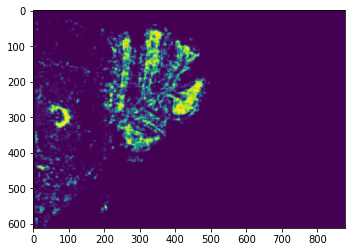

In [42]:
plt.imshow(sm);

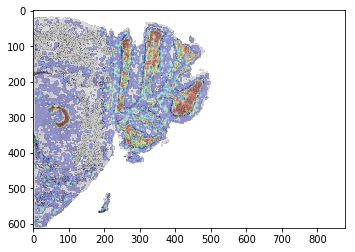

In [43]:
plt.imshow(viz);

# Examine

In [21]:
sec = 160

In [31]:
sm = \
DataManager.load_downscaled_scoremap(stack=stack, section=sec, 
                                     structure='5N',
                                     detector_id=detector_id,
                                     out_resolution_um=out_resolution_um)

In [33]:
img = DataManager.load_image_v2(stack=stack, prep_id=2, resol='thumbnail', section=sec, version='NtbNormalized')
# img = DataManager.load_image_v2(stack=stack, prep_id=2, resol='thumbnail', section=sec, version='grayJpeg')

/media/yuncong/BstemAtlasData/CSHL_data_processed/CHATM2/CHATM2_prep2_thumbnail_NtbNormalized/CHATM2_slide38_2018_01_22-S3_prep2_thumbnail_NtbNormalized.tif


Not using image_cache.


In [35]:
# ntb_to_nissl_map = np.load(DataManager.get_ntb_to_nissl_intensity_profile_mapping_filepath(stack=stack))
# img = ntb_to_nissl_map[img].astype(np.uint8)

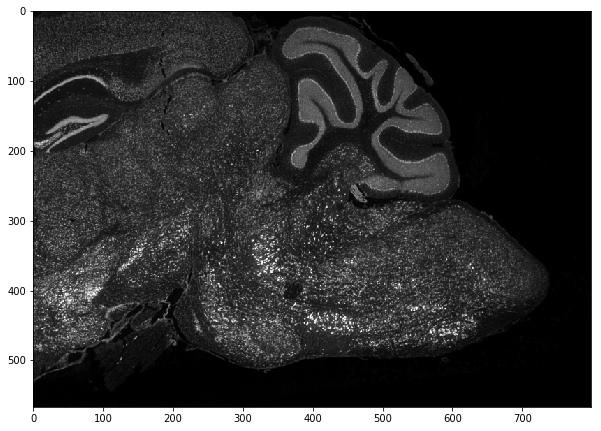

In [36]:
plt.figure(figsize=(10,10));
plt.imshow(img, cmap=plt.cm.gray);
plt.show();

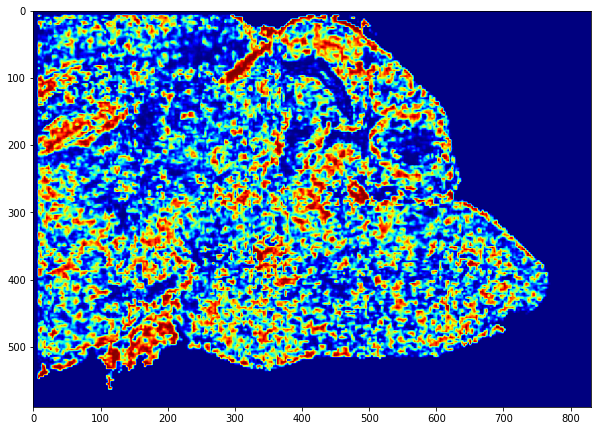

In [37]:
plt.figure(figsize=(10, 10));
plt.imshow(sm.astype(np.float), cmap=plt.cm.jet);
# plt.colorbar();

In [41]:
display_image(viz)

/home/yuncong/Brain/learning/tmp.jpg